In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

## Reading Features

statistical feature shape = (7102, 30),
LOS/NLOS labels = (array([0, 1]), array([6719,  383]))


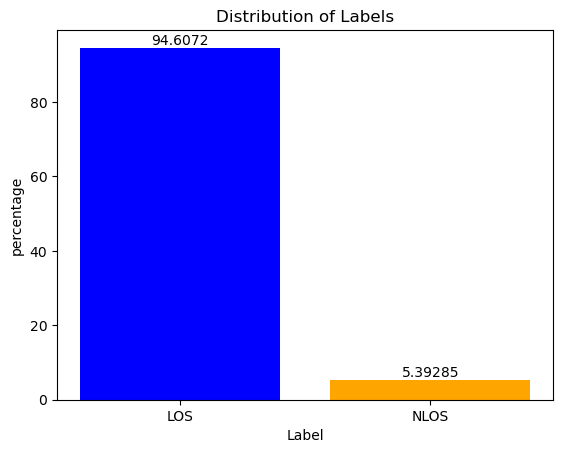

In [3]:
#PRS = np.load('PRS.npy')
FE_SNR_PRS = np.load('FE_SNR_PRS.npy')
labels = np.load('label_bs_id_11.npy')
#cor = np.load('cor.npy')
#RX = np.load('RX_time.npy')
#RX = np.stack((np.abs(RX), np.angle(RX)), axis = -2)
#print(f'RX shape = {RX.shape}\ncorrelation shape = {cor.shape}\nstatistical feature shape = {FE.shape},\nLOS = {np.unique(labels, return_counts=True)}')
FE = FE_SNR_PRS[7] #train the model with the highest noise value
print(f'statistical feature shape = {FE.shape},\nLOS/NLOS labels = {np.unique(labels, return_counts=True)}')
unique_labels, counts = np.unique(labels, return_counts=True)
class_names = ['LOS', 'NLOS']
percentage = (counts / len(labels)) * 100

fig, ax = plt.subplots()
bars = ax.bar(unique_labels, percentage, color=['blue', 'orange'])
plt.xlabel('Label')
plt.ylabel('percentage')
plt.title('Distribution of Labels')
plt.xticks(unique_labels, class_names)  # Replace with your actual label names
ax.bar_label(bars, label_type='edge')
plt.show()

SNRdB = [0, 5, 10, 15, 20]

In [4]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.decomposition import KernelPCA, PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, LearningCurveDisplay, ShuffleSplit, RandomizedSearchCV, learning_curve, validation_curve
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, ExtraTreesClassifier, StackingClassifier, BaggingClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, f1_score, average_precision_score, make_scorer
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Preprocessing Data
### Investigating transformation for dimention reduction
Dimention reduction techniques are usually based on eigen value and eigen vector decomposition. By doing this analysis, we can find that if lower numebr of features are able to explain feature variances or not. If so, a linear or non-linear dimenionality reduction technique such as PCA or LDA can be considered. 

In addition, the initial train/test split is build in this section. other preprocessing requirements sucha as scaling the data will be performed inside the pipelines

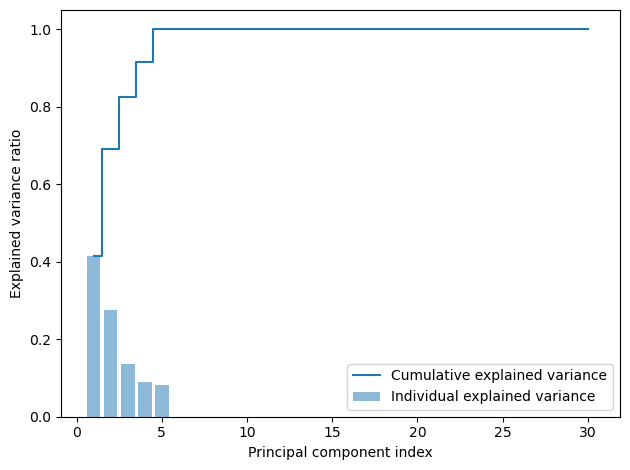

In [5]:
X = FE.reshape(FE.shape[0], -1)
cov_mat = np.cov(X.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.bar(range(1, X.shape[1]+1), var_exp, alpha=0.5, align='center',
        label='Individual explained variance')
plt.step(range(1, X.shape[1]+1), cum_var_exp, where='mid',
         label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()

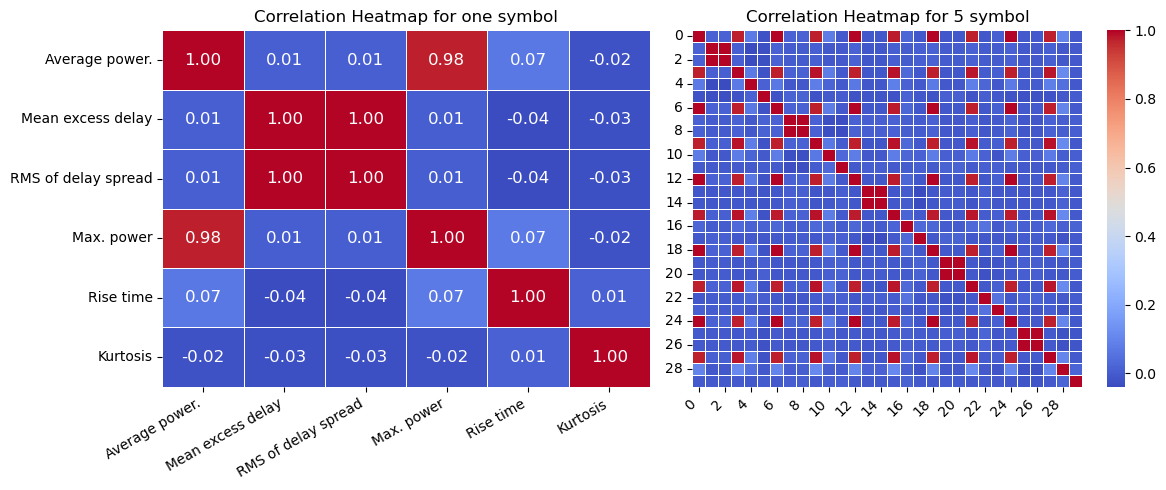

In [6]:
# Calculate the correlation matrix
correlation_matrix = np.corrcoef(X[:,:], rowvar=False)
correlation_labels = ["Average power.", "Mean excess delay", "RMS of delay spread", "Max. power", "Rise time", "Kurtosis"]
# Create a heatmap to visualize the correlation matrix

# Create a mask to display only half of the correlation matrix

# Create a heatmap to visualize the correlation matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(correlation_matrix[:6,:6], annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f", cbar=False, annot_kws={"size": 12, "va": "center", "ha": "center"}, ax=axes[0])
axes[0].set_xticklabels(correlation_labels, rotation=30, horizontalalignment='right')
axes[0].set_yticklabels(correlation_labels, rotation=0, va='center')  # Set custom y-axis labels
axes[0].set_title('Correlation Heatmap for one symbol')

sns.heatmap(correlation_matrix[:,:], annot=False, cmap='coolwarm', linewidths=0.5, fmt=".2f", cbar=True, annot_kws={"size": 12, "va": "center", "ha": "center"}, ax=axes[1])
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, horizontalalignment='right')
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0, va='center')  # Set custom y-axis labels if needed
axes[1].set_title('Correlation Heatmap for 5 symbol')

plt.tight_layout()
plt.show()

In [7]:
#selecting one of highly correlated statistical features
ind = np.array([0, 1, 4, 5, 0+6, 1+6, 4+6, 5+6, 0+12, 1+12, 4+12, 5+12, 0+18, 1+18, 4+18, 5+18, 0+24, 1+24, 4+24, 5+24])
XX = X[:,ind]
XX.shape

(7102, 20)

In [34]:
#column_names =[correlation_labels[0], correlation_labels[1], correlation_labels[4], correlation_labels[5]] * 5
column_names = correlation_labels*5
df = pd.DataFrame(X, columns = column_names)
des = df.iloc[:,:6].describe()
des
#latex_table = des.to_latex(index=True)
# Print or save the LaTeX code
#print(latex_table)

,Average power.,Mean excess delay,RMS of delay spread,Max. power,Rise time,Kurtosis
count,7102.000000,7102.000000,7102.000000,7102.000000,7102.000000,7.102000e+03
mean,0.000038,0.017058,0.595357,0.010579,8.323574,1.172447e+03
std,0.000027,0.000115,0.008002,0.003255,20.927303,7.294159e-09
min,0.000007,0.016648,0.567041,0.004332,-205.454926,1.172447e+03
25%,0.000023,0.016982,0.590035,0.008521,0.000000,1.172447e+03
50%,0.000029,0.017056,0.595224,0.009651,0.000000,1.172447e+03
75%,0.000042,0.017136,0.600769,0.011696,4.717517,1.172447e+03
max,0.000195,0.017475,0.624765,0.027118,276.589569,1.172447e+03


the table above indicates that selecting a specific scaler is not a trivial task. Thus, It is better to have a pool of scalers such as standarzer() to select the best pipeline. However, it is clear that the statidstical features, e.g. max_power or kurtosis, is the same for each symbols as they have the same MEAN_STD AWGN values, e.g. column 0 and 4 in above table corresponding to average power.   

## Naive grid serach for best pipeline
In this section, we are looking for an initial architecture with a proper performance in terms of accuracy and roc-auc to use it as a baseline for learning transformer hyper parameters. To do so, a RandomizedSearch with 10 fold stratified cross validation is used. 
[Cross validation procedure to avoid overfitting](https://scikit-learn.org/stable/_images/grid_search_workflow.png) <br> <br>
<div style="text-align:center;">
<a href="https://scikit-learn.org">
    <img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" width="500" height="300">
</a>
</div>



In [27]:
#Train test split by using reduced statistical feature inputs
X_train, X_test, y_train, y_test = train_test_split(XX, labels, test_size=0.2, random_state=42, stratify=labels)

In [28]:
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'Normalizer': Normalizer(),
}

transformers = {
    'PCA': PCA(n_components=None, random_state = 47),  
    'KernelPCA': KernelPCA(n_components=None, random_state = 47),  
    'LinearDiscriminantAnalysis': LinearDiscriminantAnalysis(),
    'TruncatedSVD': TruncatedSVD(random_state = 47)

}

estimators = {
#classic estimators
    'LogisticRegression': LogisticRegression(random_state=1234),
    'SVM': SVC(probability=True, random_state=1234),
    'SGD': SGDClassifier(random_state = 1234),
    'KNN': KNeighborsClassifier(),
    #'RadiusNeighbhborsClassifier': RadiusNeighborsClassifier(),
    'NaiveBayes': GaussianNB(), 
#boosting / ensemble estimators 
    'DecisionTree': DecisionTreeClassifier(random_state = 1234),
    'RandomForest': RandomForestClassifier(random_state=1234),
    'GradientBoosting': GradientBoostingClassifier(random_state=1234),
    'ExtraTreesClassifier': ExtraTreesClassifier(random_state=1234),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=1234),
#Classic MLP, carried on on Scikit learn
    'MLP': MLPClassifier(random_state=1234, hidden_layer_sizes=(50,50,50), activation='relu', solver='adam', alpha=0.0001, max_iter=1000), 
    #without this params for MLP the algorithm is not converged by using default params. these params will be tunned more in the next step
}
param_grids = {
        'scaler': list(scalers.values()),
        'transformer': list(transformers.values()),
        'estimator': list(estimators.values())
    }

pipeline = Pipeline([
    ('scaler', None),
    ('transformer', None),
    ('estimator', None)
])

n_splits = 10
stratified_kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
scoring = {'Accuracy': 'accuracy', "AUC": "roc_auc", 'f1': 'f1'}
#random_search = RandomizedSearchCV(
#    estimator=pipeline,
#    param_distributions = param_grids,
#    n_iter = 10,
#    cv = stratified_kf,
#    n_jobs = -1,
#    verbose = 1,
#    random_state = 2561,
#    scoring = scoring,
#    refit= 'AUC'
#)
#random_search.fit(X_train, y_train)

search = GridSearchCV(estimator = pipeline, param_grid = param_grids, cv = 5, n_jobs = -1, verbose = 1, scoring = scoring, refit= 'AUC', return_train_score=True)
search.fit(X_train, y_train)

# Get the best parameters for each step
#best_scaler = random_search.best_params_['scaler']
#best_transformer = random_search.best_params_['transformer']
#best_estimator = random_search.best_params_['estimator']
# Now you can use the best parameters to construct the final pipeline
#final_pipeline = Pipeline([
#    ('scaler', best_scaler),
#    ('transformer', best_transformer),
#    ('estimator', best_estimator)
#])
# Fit the final pipeline to the training data
#final_pipeline.fit(X_train, y_train)
#final_pipeline

# this code makes a latex table from sclaer, trnansformer and estimator dictionaries 
#s1 = list(scalers.keys()) 
#t1 =  list(transformers.keys()) 
#e1 = list(estimators.keys())
#pipe_table = pd.DataFrame(list(zip(s1, t1, e1)), columns=['Scaler', 'Transformer', 'Classifier'])
#print(pipe_table.to_latex(index=False))

Fitting 5 folds for each of 176 candidates, totalling 880 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', None), ('transformer', None),
                                       ('estimator', None)]),
             n_jobs=-1,
             param_grid={'estimator': [LogisticRegression(random_state=1234),
                                       SVC(probability=True, random_state=1234),
                                       SGDClassifier(random_state=1234),
                                       KNeighborsClassifier(), GaussianNB(),
                                       DecisionTreeClassifier(random_state=1234),
                                       RandomForestClassifier(r...
                                       MLPClassifier(hidden_layer_sizes=(50, 50,
                                                                         50),
                                                     max_iter=1000,
                                                     random_state=1234)],
                         'scaler': [StandardScaler(), MinMaxScaler(),
                                    RobustScaler(), Normalizer()],
                         'transformer': [PCA(random_state=47),
                                         KernelPCA(random_state=47),
                                         LinearDiscriminantAnalysis(),
                                         TruncatedSVD(random_state=47)]},
             refit='AUC', return_train_score=True,
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy', 'f1': 'f1'},
             verbose=1)

In [29]:
# SOrting 50 best pipelines that are trained from 880 instances of fits in naive first step of GridSearch for best pipelines 
print(search.cv_results_.keys())
scores = search.cv_results_['rank_test_AUC']
param_sets = search.cv_results_['params']

# Find the indices that would sort the scores in descending order
sorted_indices = np.argsort(scores)
#Get the 5 best parameter sets and their corresponding scores
best_param_sets = [param_sets[i] for i in sorted_indices[:60]]
best_scores = [scores[i] for i in sorted_indices[:60]]
# Print the best parameter sets and scores
for i, (params, score) in enumerate(zip(best_param_sets, best_scores)):
    print(f"Rank {i + 1}: Parameters: {params}, Rank (based on AUC test): {score:.0f}")


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_estimator', 'param_scaler', 'param_transformer', 'params', 'split0_test_Accuracy', 'split1_test_Accuracy', 'split2_test_Accuracy', 'split3_test_Accuracy', 'split4_test_Accuracy', 'mean_test_Accuracy', 'std_test_Accuracy', 'rank_test_Accuracy', 'split0_train_Accuracy', 'split1_train_Accuracy', 'split2_train_Accuracy', 'split3_train_Accuracy', 'split4_train_Accuracy', 'mean_train_Accuracy', 'std_train_Accuracy', 'split0_test_AUC', 'split1_test_AUC', 'split2_test_AUC', 'split3_test_AUC', 'split4_test_AUC', 'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC', 'split0_train_AUC', 'split1_train_AUC', 'split2_train_AUC', 'split3_train_AUC', 'split4_train_AUC', 'mean_train_AUC', 'std_train_AUC', 'split0_test_f1', 'split1_test_f1', 'split2_test_f1', 'split3_test_f1', 'split4_test_f1', 'mean_test_f1', 'std_test_f1', 'rank_test_f1', 'split0_train_f1', 'split1_train_f1', 'split2_train_f1', 'split3_train_f1', 'spli

In [92]:
unique_classifiers = set()
selected_pipes = []
for item in best_param_sets:
    classifier = item['estimator']
    if classifier not in unique_classifiers:
        unique_classifiers.add(classifier)
        selected_pipes.append(item)

top_pipelines = [Pipeline([
    ('scaler', pipe['scaler']),
    ('transformer', pipe['transformer']),
    ('estimator', pipe['estimator'])
]) for pipe in selected_pipes]


In [93]:
# Extract information about each step and make a top nine pipeline table
df = pd.DataFrame()
for i in top_pipelines:
    steps_data ={} 
    for step_name, step_object in i.steps :
        steps_data[step_name] = type(step_object).__name__
    #steps_data[step_name + '_Parameters'] = step_object.get_params()

# Create a DataFrame with one row and columns representing each step
        steps_df = pd.DataFrame(steps_data, index=[0])
    df = pd.concat([df, steps_df], ignore_index = True)
df.index.name = 'Rank'
df.index = range(1,10)
# Display the DataFrame
print(df)#.to_latex())

           scaler   transformer                   estimator
1    RobustScaler     KernelPCA          LogisticRegression
2  StandardScaler           PCA               SGDClassifier
3    MinMaxScaler  TruncatedSVD               MLPClassifier
4    MinMaxScaler  TruncatedSVD                         SVC
5  StandardScaler  TruncatedSVD                  GaussianNB
6    MinMaxScaler  TruncatedSVD  GradientBoostingClassifier
7    MinMaxScaler  TruncatedSVD          AdaBoostClassifier
8    MinMaxScaler     KernelPCA        ExtraTreesClassifier
9  StandardScaler           PCA      RandomForestClassifier


In [31]:
estimator_params = {
    'LogisticRegression': {
        'estimator__class_weight' : [None, 'balanced', {0: 1, 1: 2}, {0: 0.5, 1: 1}],
        'estimator__C': [0.001, 0.01, 0.1, 1.0, 10.0],
        'estimator__max_iter':[500] #increase number of iteration to converge 
        #'estimator__solver': ['lbfgs', 'liblinear'],
        #'estimator__max_iter': [100, 200, 500, 1000],
    },
    'SGDClassifier': {
        'estimator__loss': ['modified_huber'], 
        #other loss functions leads to a classifier that is already investigated in this code, 
        # e.g. log_loss == logistic regression
        # modified_huber is a probabilistic estimator with tolerance to outliers
        'estimator__alpha': [0.001, 0.01, 0.1, 0.2],
        'estimator__max_iter':[2000] #increase number of iteration to converge 
        #'estimator__class_weight' : [None, 'balanced', {0: 1, 1: 2}, {0: 0.5, 1: 1}],
        #'estimator__max_iter': [int(np.ceil(10**6 / X_train.shape[0]))],
        #'estimator__penalty': ['l2', 'l1', 'elasticnet'],
        #'estimator__learning_rate': ['optimal', 'adaptive'],
    },
    'MLPClassifier': {
        'estimator__hidden_layer_sizes': [(50, 50), (100, 100), (50, 100, 50)],
        'estimator__alpha': [0.0001, 0.001, 0.01],
        'estimator__learning_rate_init': [0.0001, 0.001, 0.01],
    },
    'SVC': {
        #'estimator__kernel': ['linear', 'rbf', 'sigmoid'],
        #'estimator__class_weight' : [None, 'balanced', {0: 1, 1: 2}, {0: 0.5, 1: 1}],
        'estimator__C': [0.1, 1, 10],
        'estimator__gamma': [0.1, 1, 'scale', 'auto'],
    },
    'ExtraTreesClassifier': {
        'estimator__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
        'estimator__max_depth': [None, 10, 20, 30],          # Maximum depth of the tree
        #'estimator__min_samples_leaf': [1, 2, 4], 
        #'max_features': ['auto', 'sqrt', 'log2'], # Number of features to consider for the best split # Minimum number of samples required to be at a leaf node
        },
    'GradientBoostingClassifier': {
        'estimator__n_estimators': [50, 100, 150], 
        'estimator__learning_rate': [0.01, 0.1],
        #'estimator__max_depth': [3, 4 ,5],
        #'estimator__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
        #'estimator__min_samples_leaf': [2, 4, 6],  # Minimum number of samples required to be at a leaf node
        },
    'AdaBoostClassifier': {
        #'estimator__class_weight' : [None, 'balanced', {0: 1, 1: 2}, {0: 0.5, 1: 1}],
        'estimator__n_estimators': [50, 100, 200], 
        'estimator__learning_rate': [0.01, 0.1, 0.2],          # Minimum samples required to split a node
        #'estimator__estimator': [DecisionTreeClassifier(max_depth=2), DecisionTreeClassifier(max_depth=4), RandomForestClassifier(n_estimators=50), RandomForestClassifier(n_estimators=100) ],            # Minimum samples required at each leaf node
        },
    'GaussianNB': {
        'estimator__var_smoothing': [1e-9, 1e-7, 1e-5]
        },
    'RandomForestClassifier': {
        #'estimator__class_weight' : [None, 'balanced', {0: 1, 1: 2}, {0: 0.5, 1: 1}],
        'estimator__n_estimators': [50, 100, 200], 
        #'estimator__max_depth': [None, 10, 20, 30],
        #'estimator__min_samples_split': [2, 5, 10],          # Minimum samples required to split a node
        #'estimator__min_samples_leaf': [2, 4, 8],            # Minimum samples required at each leaf node
        #'estimator__max_features': [None, 'sqrt', 'log2'],  # Number of features to consider for the best split
        #'estimator__criterion': ['gini', 'entropy'],
        },
    }

### Grid search for best hyper parameters of each top pipeline

In [32]:
#Hyper parameter tunning of top pipeline through a new grid search
est_times = []
est_names = []
est_f1 = []
est_AUC = []
est_accuracy = []
results = {}
for pipeline in top_pipelines:
    est_name = pipeline.named_steps['estimator'].__class__.__name__
    start_time = time.time()
    gs = GridSearchCV(estimator=pipeline, 
                  param_grid = estimator_params[est_name], 
                  scoring = scoring,
                  refit= 'AUC',
                  cv = stratified_kf,
                  n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    end_time = time.time()
    elapsed_time = end_time - start_time
    est_times.append(elapsed_time)
    est_names.append(est_name)
    best_AUC = gs.best_score_
    est_AUC.append(best_AUC)
    print(f'estimator: {est_name}')
    print(f'best AUC score: {best_AUC}')
    print(f'best params: {gs.best_params_}')
    print(f'elapsed time: {elapsed_time:.2f} second')
    pipeline.set_params(**gs.best_params_)
    best_f1 = max(gs.cv_results_['mean_test_f1'])
    best_acc = max(gs.cv_results_['mean_test_Accuracy']) 
    est_f1.append(best_f1)
    est_accuracy.append(best_acc)
    results[est_name] = gs.cv_results_

estimator: LogisticRegression
best AUC score: 0.9738557334085449
best params: {'estimator__C': 100.0, 'estimator__class_weight': {0: 1, 1: 2}, 'estimator__max_iter': 500}
elapsed time: 1699.87 second
estimator: SGDClassifier
best AUC score: 0.9735067785190985
best params: {'estimator__alpha': 0.001, 'estimator__loss': 'modified_huber', 'estimator__max_iter': 2000}
elapsed time: 0.38 second
estimator: MLPClassifier
best AUC score: 0.972606839639548
best params: {'estimator__alpha': 0.01, 'estimator__hidden_layer_sizes': (100, 100), 'estimator__learning_rate_init': 0.0001}
elapsed time: 136.42 second
estimator: SVC
best AUC score: 0.9724954997082431
best params: {'estimator__C': 0.1, 'estimator__gamma': 0.1}
elapsed time: 11.45 second
estimator: GaussianNB
best AUC score: 0.9675174546113112
best params: {'estimator__var_smoothing': 1e-05}
elapsed time: 0.13 second
estimator: GradientBoostingClassifier
best AUC score: 0.9708657654694249
best params: {'estimator__learning_rate': 0.1, 'esti

### Comparing Trained Top pipeline performane

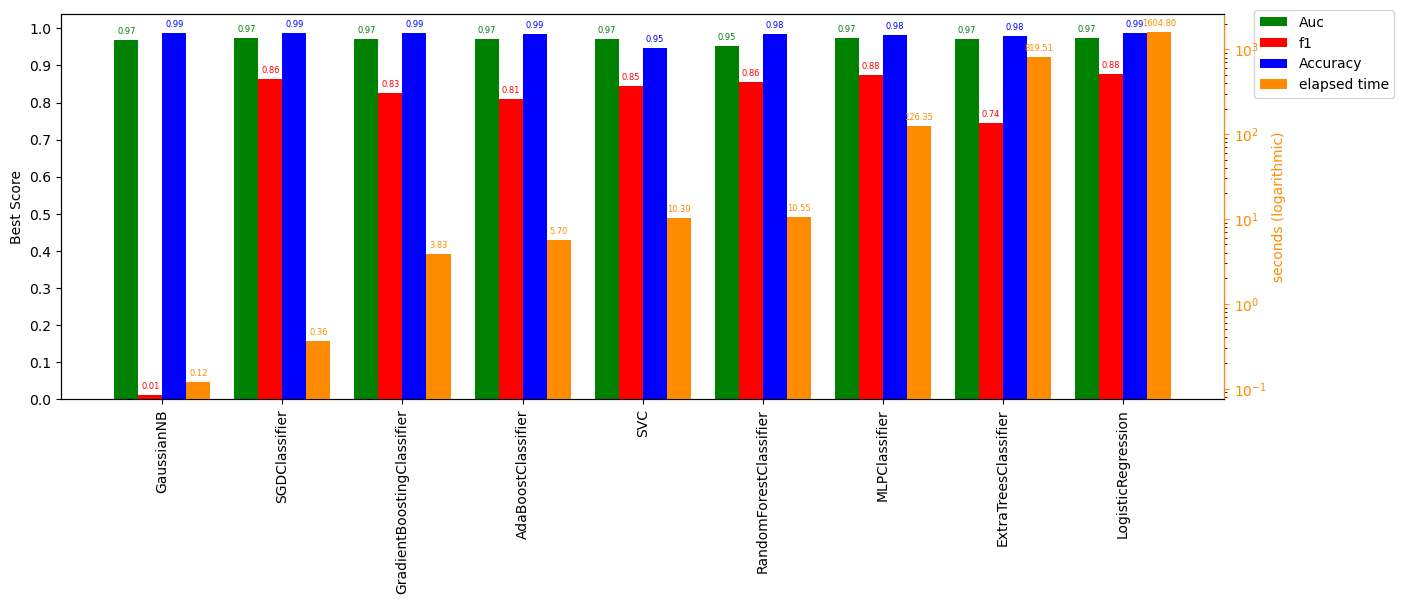

In [14]:
#Sorting data based on elapsed time
sorted_indices = sorted(range(len(est_times)), key=lambda i: est_times[i], reverse=False)
est_names = [est_names[i] for i in sorted_indices]
est_AUC = [est_AUC[i] for i in sorted_indices]
est_f1 = [est_f1[i] for i in sorted_indices]
est_times = [est_times[i] for i in sorted_indices]

x = np.arange(len(est_names))  # x-axis locations for the bars
width = 0.2  # Width of the bars

# Create the bar chart for the first dataset
fig, ax1 = plt.subplots(figsize=(15, 5))
bar_f1 = ax1.bar(x , est_AUC, width, label='Auc', color = 'g')
bar_f2 = ax1.bar(x+width , est_f1, width, label='f1', color = 'red')
bar_f3 = ax1.bar(x +2*width, est_accuracy, width, label='Accuracy', color = 'blue')
ax1.set_xticks(x+1.5*width, est_names, rotation = 90)
ax1.set_yticks(np.arange(0,1.1,0.1))
ax1.set_ylabel('Best Score')
ax1.bar_label(bar_f1, fmt = '%.2f', label_type='edge', padding=3, color = 'g', fontsize = 6)
ax1.bar_label(bar_f2, fmt = '%.2f', label_type='edge', padding=3, color = 'r', fontsize = 6)
ax1.bar_label(bar_f3, fmt = '%.2f', label_type='edge', padding=3, color = 'b', fontsize = 6)

ax2 = ax1.twinx()
bar_f4 = ax2.bar(x+3*width, est_times, width, label='elapsed time', log = True, color = 'darkorange')
ax2.set_ylabel('seconds (logarithmic)', color = 'darkorange')
ax2.spines['right'].set_color('darkorange')
ax2.yaxis.label.set_color('darkorange')
ax2.tick_params(axis='y', colors='darkorange')
ax2.bar_label(bar_f4, fmt = '%.2f', label_type='edge', padding=3, color = 'darkorange', fontsize = 6)

# Combine legends for both y-axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
combined_labels = labels1 + labels2
ax1.legend(lines1 + lines2, combined_labels, loc='upper left', bbox_to_anchor=(1.02, 1.03), frameon=True)
plt.show()


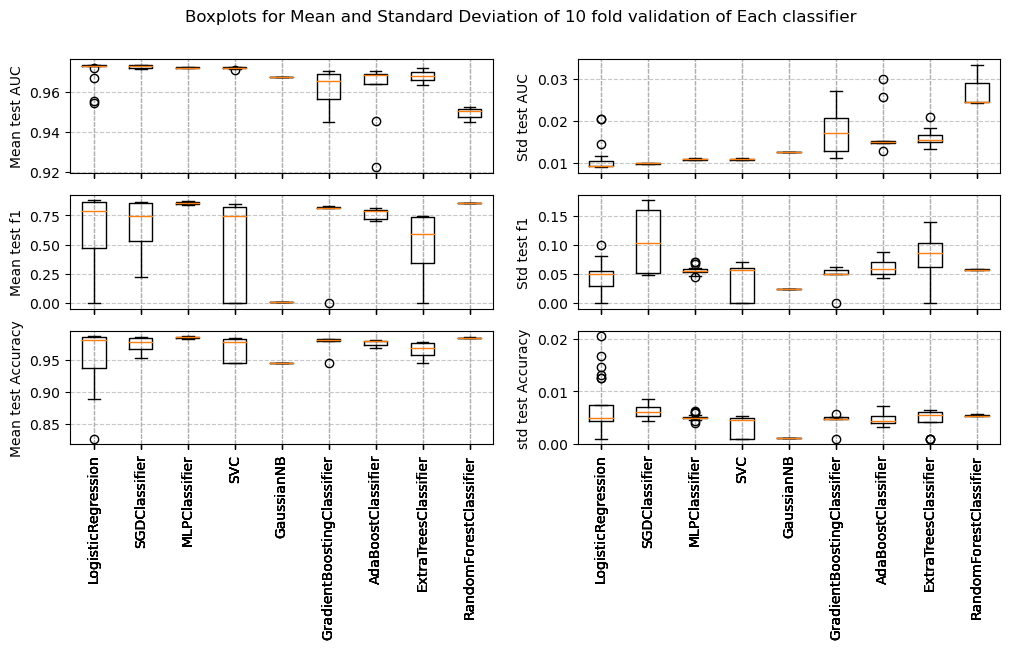

In [15]:
# Create two subplots for 'mean' and 'std'
fig, axs = plt.subplots(3, 2, figsize=(12, 5), sharex=True)
fig.suptitle('Boxplots for Mean and Standard Deviation of 10 fold validation of Each classifier')
# Boxplot for 'mean' values
axs[0][0].boxplot([results[key]['mean_test_AUC'] for key in results.keys()], labels=results.keys())
axs[0][0].set_ylabel('Mean test AUC')
axs[0][0].grid(True, linestyle='--', alpha=0.7)

axs[2][0].set_xticklabels(results.keys(), rotation=90)
axs[2][1].set_xticklabels(results.keys(), rotation=90)
# Boxplot for 'std' values
axs[0][1].boxplot([results[key]['std_test_AUC'] for key in results.keys()], labels=results.keys())
axs[0][1].set_ylabel('Std test AUC')
#axs[0][1].set_xticklabels(results.keys(), rotation=90)
axs[0][1].grid(True, linestyle='--', alpha=0.7)

axs[1][0].boxplot([results[key]['mean_test_f1'] for key in results.keys()], labels=results.keys())
axs[1][0].set_ylabel('Mean test f1')
#axs[1][0].set_xticklabels(results.keys(), rotation=90)
axs[1][0].grid(True, linestyle='--', alpha=0.7)

axs[1][1].boxplot([results[key]['std_test_f1'] for key in results.keys()], labels=results.keys())
axs[1][1].set_ylabel('Std test f1')
#axs[1][1].set_xticklabels(results.keys(), rotation=90)
axs[1][1].grid(True, linestyle='--', alpha=0.7)

axs[2][0].boxplot([results[key]['mean_test_Accuracy'] for key in results.keys()], labels=results.keys())
axs[2][0].set_ylabel('Mean test Accuracy')
axs[2][0].grid(True, linestyle='--', alpha=0.7)

axs[2][1].boxplot([results[key]['std_test_Accuracy'] for key in results.keys()], labels=results.keys())
axs[2][1].set_ylabel('std test Accuracy')
axs[2][1].grid(True, linestyle='--', alpha=0.7)


plt.show()

### Investigating top pipeline performance

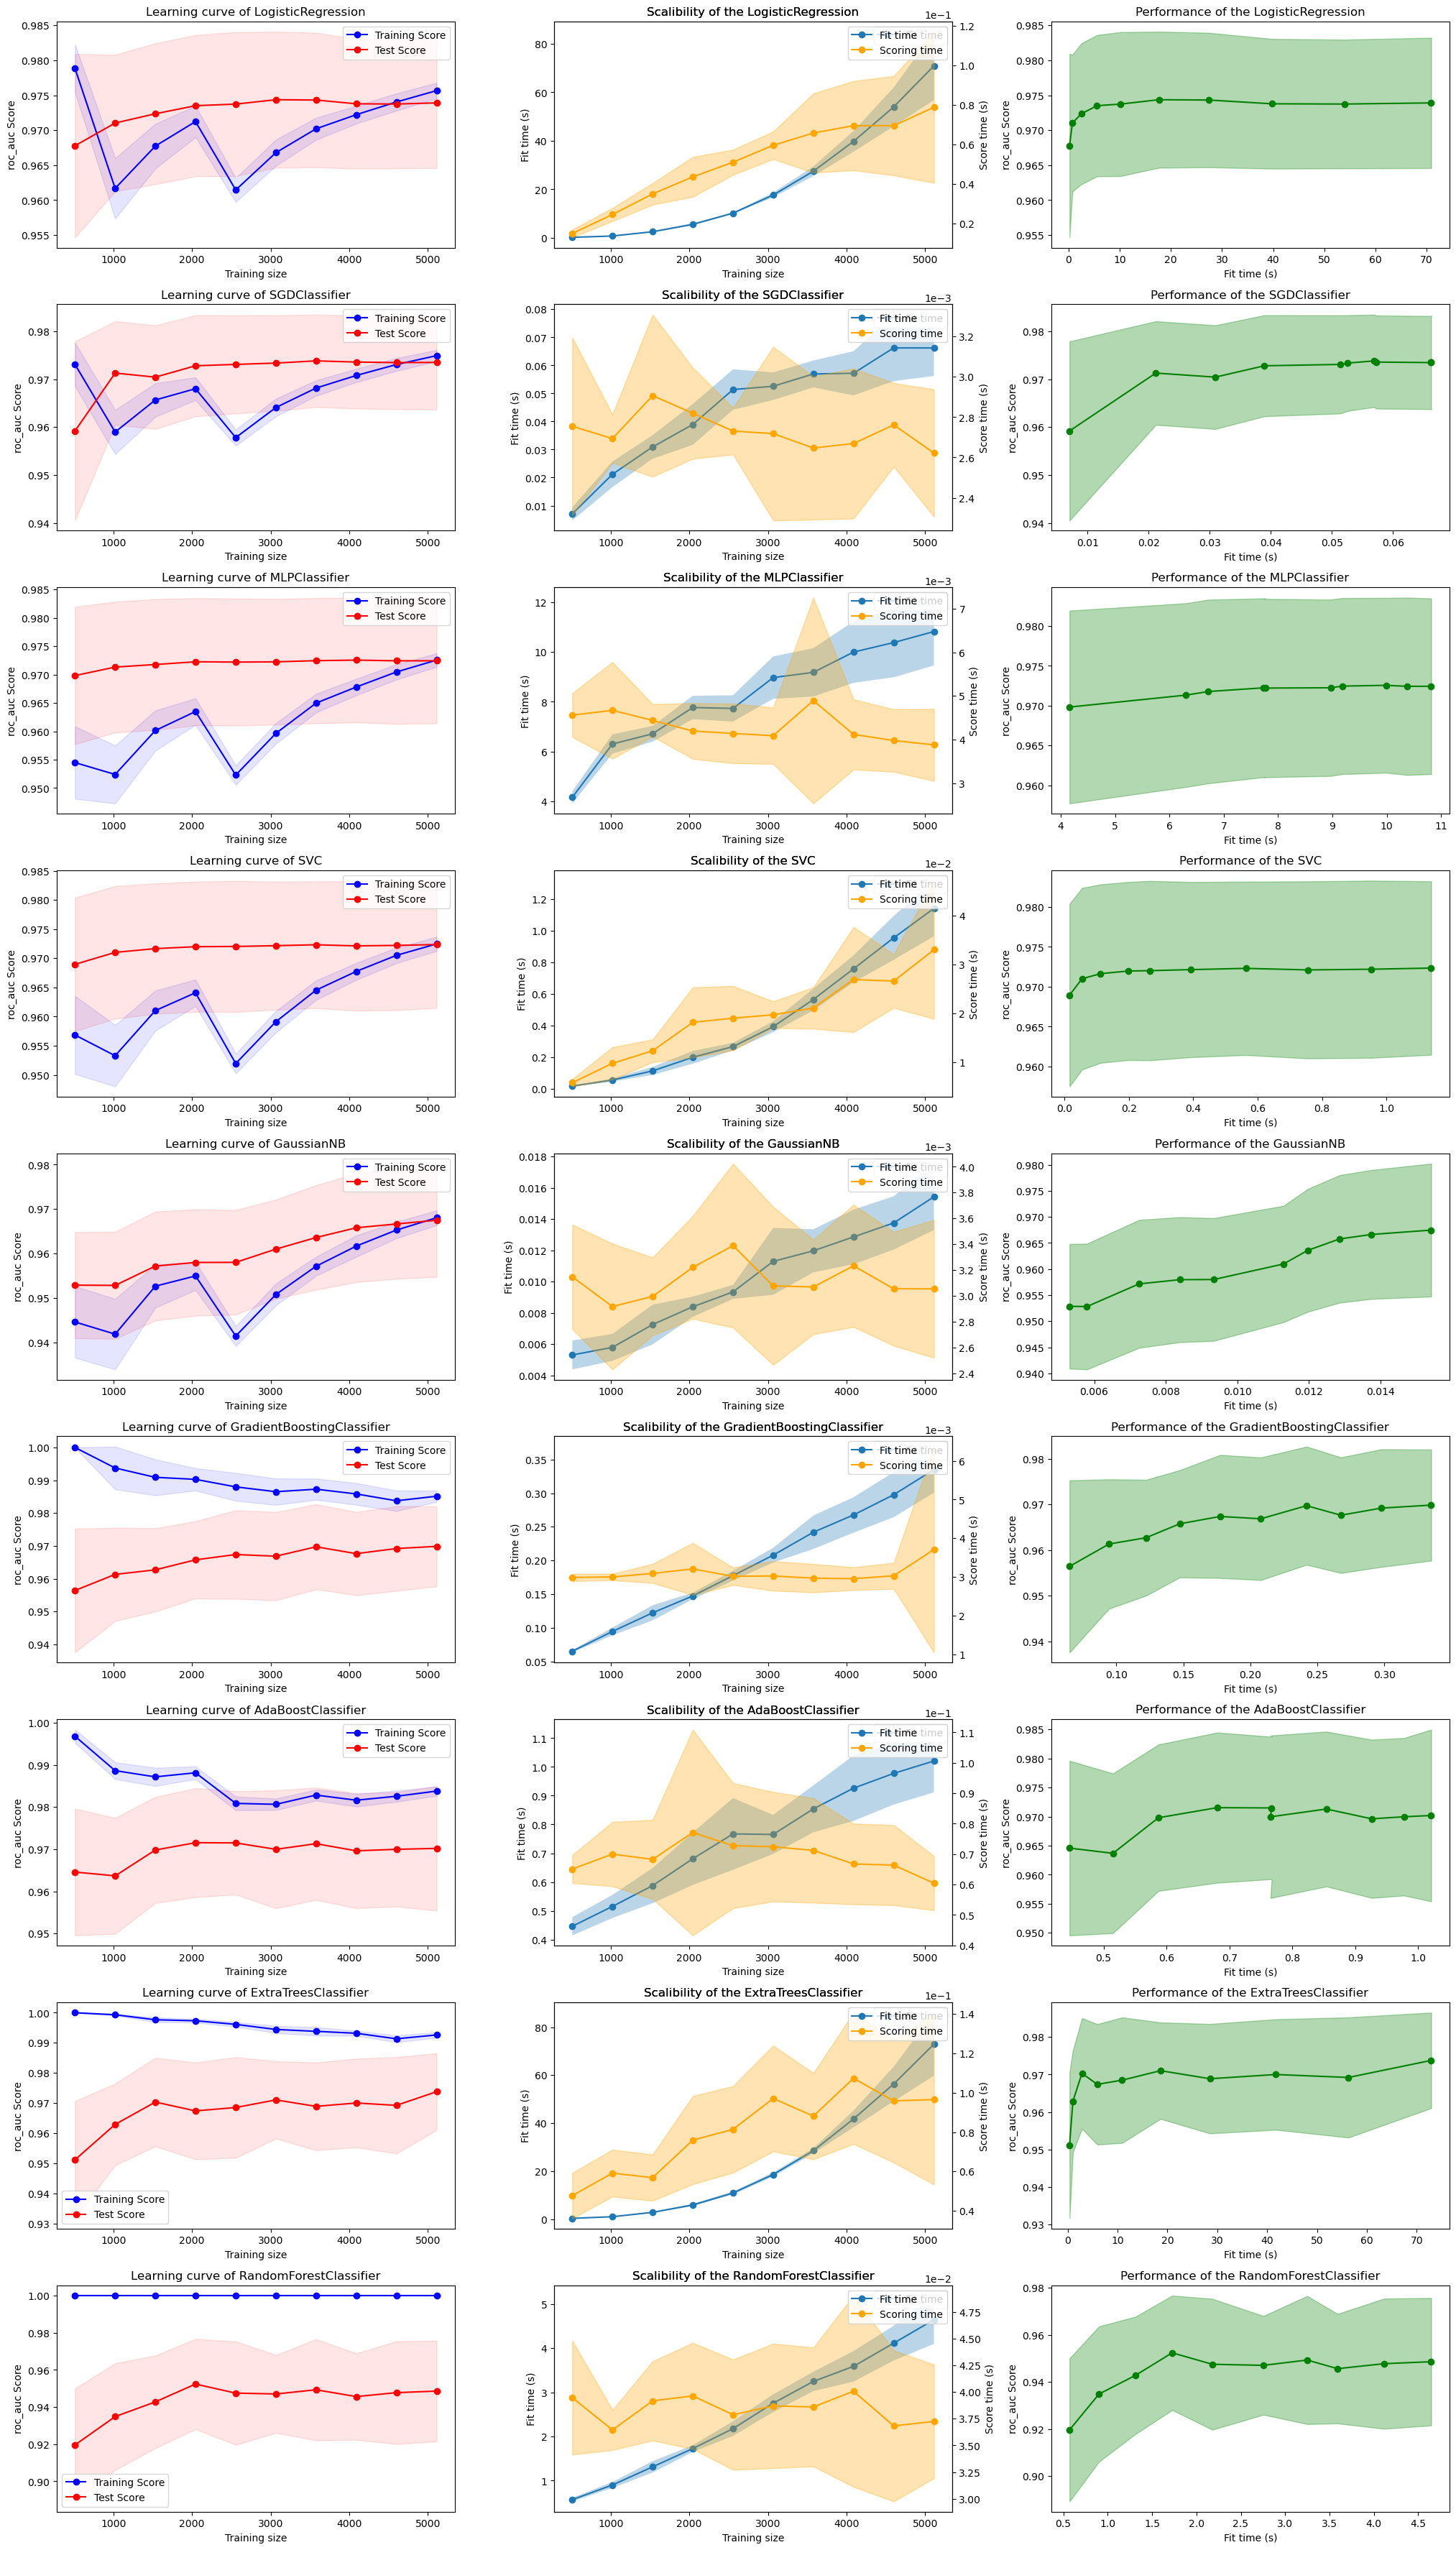

In [94]:
n_splits = 10
common_params = {
    "X": X_train,
    "y": y_train,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": stratified_kf,
    "n_jobs": -1,
    #"line_kw": {"marker": "o"},
    #"std_display_style": "fill_between",
    "scoring": 'roc_auc',
    'return_times': True, 
}



fig, ax = plt.subplots(nrows=len(top_pipelines), ncols=3, figsize=(25, 45))
plt.subplots_adjust(wspace=0.25, hspace=0.25)
for ax_idx, pipeline in enumerate(top_pipelines):
# Learning curve for top 5 pipelines
    est_name = pipeline.named_steps['estimator'].__class__.__name__
    train_sizes, train_scores, test_scores, fit_times, score_times = learning_curve(pipeline, **common_params, verbose = 0)
    
    # Calculate the mean and standard deviation of training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    

    # Plot training and test scores
    ax[ax_idx][0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="b")
    ax[ax_idx][0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="r")
    ax[ax_idx][0].plot(train_sizes, train_scores_mean, 'o-', color="b", label="Training Score")
    ax[ax_idx][0].plot(train_sizes, test_scores_mean, 'o-', color="r", label="Test Score")
    ax[ax_idx][0].legend(loc="best")
    
    
    ax[ax_idx][0].set_title(f'Learning curve of {est_name}')
    ax[ax_idx][0].set_xlabel("Training size")
    ax[ax_idx][0].set_ylabel(f"{common_params['scoring']} Score")

#Validation curve for top pipelines
# scalability regarding the fit time
    ax[ax_idx][1].plot(train_sizes, fit_times.mean(axis=1), "o-", label="Fit time")
    ax[ax_idx][1].fill_between(
        train_sizes,
        fit_times.mean(axis=1) - fit_times.std(axis=1),
        fit_times.mean(axis=1) + fit_times.std(axis=1),
        alpha=0.3,
    )
    ax[ax_idx][1].set_xlabel("Training size")
    ax[ax_idx][1].set_ylabel("Fit time (s)")
    ax[ax_idx][1].set_title(f'Scalibility of the {est_name}')
    ax[ax_idx][1].legend(loc="best")

# scalability regarding the score time
    axx = ax[ax_idx][1].twinx()
    axx.plot(train_sizes, score_times.mean(axis=1), "o-", color = 'orange', label="Scoring time")
    axx.fill_between(
        train_sizes,
        score_times.mean(axis=1) - score_times.std(axis=1),
        score_times.mean(axis=1) + score_times.std(axis=1),
        alpha=0.3, color = 'orange'
    )
    axx.ticklabel_format(axis='y', style='sci', scilimits=(0,0)) 
    axx.set_xlabel("Training size")
    axx.set_ylabel("Score time (s)")
    axx.set_title(f'Scalibility of the {est_name}')
    axx.legend(loc="best")

    lines, l = ax[ax_idx][1].get_legend_handles_labels()
    lines2, l2 = axx.get_legend_handles_labels()
    axx.legend(lines + lines2, l + l2, loc='upper right')

# Pipeline performance based to test score 
    ax[ax_idx][2].plot(fit_times.mean(axis=1), test_scores.mean(axis=1), "o-", color="g")
    ax[ax_idx][2].fill_between(
        fit_times.mean(axis=1),
        test_scores.mean(axis=1) - test_scores.std(axis=1),
        test_scores.mean(axis=1) + test_scores.std(axis=1),
        alpha=0.3, color="g"
    )
    ax[ax_idx][2].set_ylabel(f"{common_params['scoring']} Score")
    ax[ax_idx][2].set_xlabel("Fit time (s)")
    ax[ax_idx][2].set_title(
        f"Performance of the {est_name}"
    )
#LearningCurveDisplay.from_estimator(pipeline, **common_params, ax=ax[ax_idx, 0])
#handles, label = ax[ax_idx, 0].get_legend_handles_labels()
#ax[ax_idx][0].legend(handles[:2], ["Training Score", "Test Score"])
#est_name = pipeline.named_steps['estimator'].__class__.__name__
#ax[ax_idx][0].set_title(est_name)

### Find the optimum Threshold based on 10-fold cross validatio and visualizing ROC curve and confusion matrix

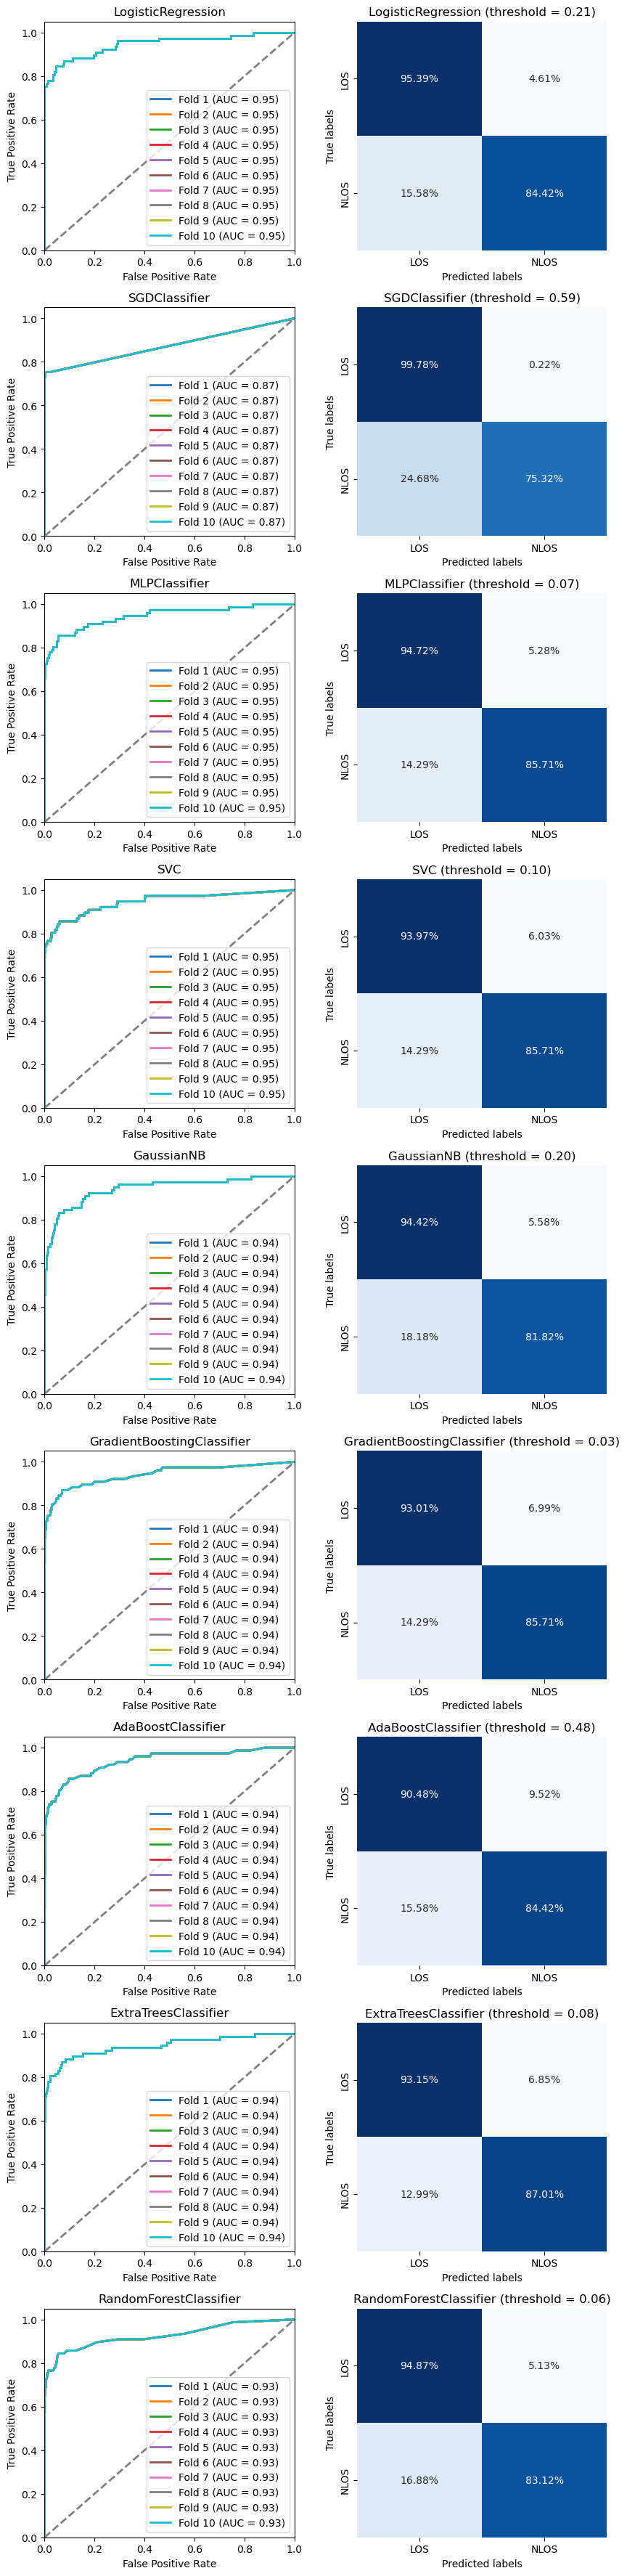

In [95]:
fig, ax = plt.subplots(nrows=len(top_pipelines), ncols=2, figsize=(10, 45))
plt.subplots_adjust(wspace=0.25, hspace=0.25)
for ax_idx, pipeline in enumerate(top_pipelines):
#ROC curve for top 5 pipelines
    all_fpr = []
    all_tpr = []
    all_auc = []
    all_threshold = []
    # Create an instance of StratifiedKFold with 10 folds
    n_splits = 10
    for fold, (train_index, test_index) in enumerate(stratified_kf.split(X_train, y_train), n_splits):
        XX_train, XX_test = XX[train_index], XX[test_index]
        yy_train, yy_test = labels[train_index], labels[test_index]
    
    # Fit the pipeline on the training data for the current fold
        pipeline.fit(X_train, y_train)
    
    # Get the predicted probabilities for the positive class
        y_prob = pipeline.predict_proba(X_test)
    
    # Compute ROC curve
        fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1], drop_intermediate = True)

        optimal_threshold_index = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_threshold_index]
    # Calculate AUC
        roc_auc_fold = auc(fpr, tpr)

    # Store ROC data for this fold
        all_fpr.append(fpr)
        all_tpr.append(tpr)
        all_auc.append(roc_auc_fold)
        all_threshold.append(optimal_threshold)
        est_name = pipeline.named_steps['estimator'].__class__.__name__

    # Plot the ROC curves for each fold
    for fold in range(n_splits):
        ax[ax_idx][0].plot(all_fpr[fold], all_tpr[fold], lw=2, label=f'Fold {fold+1} (AUC = {all_auc[fold]:.2f})')

    ax[ax_idx][0].plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    ax[ax_idx][0].set_xlim([0.0, 1.0])
    ax[ax_idx][0].set_ylim([0.0, 1.05])
    ax[ax_idx][0].set_xlabel('False Positive Rate')
    ax[ax_idx][0].set_ylabel('True Positive Rate')
    ax[ax_idx][0].set_title(f'{est_name}')
    ax[ax_idx][0].legend(loc='lower right')

#COnfusion matrix based based on optimal threshold
    custom_threshold = np.mean(all_threshold)
    y_pred = (y_prob[:, 1] >= custom_threshold).astype(int)  # Assuming binary classification
    cm = confusion_matrix(y_test, y_pred, normalize = 'true')
    sns.heatmap(cm, annot=True,  cbar = False, cmap="Blues", fmt=".2%", xticklabels=class_names, yticklabels=class_names, ax = ax[ax_idx, 1])
    ax[ax_idx, 1].set_xlabel("Predicted labels")
    ax[ax_idx, 1].set_ylabel("True labels")
    ax[ax_idx, 1].set_title(f'{est_name} (threshold = {custom_threshold:.2f})')
    

### Testing Voting classification performance

Accuracy of the VotingClassifier Classifier: 0.9345531315974666


Text(0.5, 1.0, 'VotingClassifier (threshold = 0.06)')

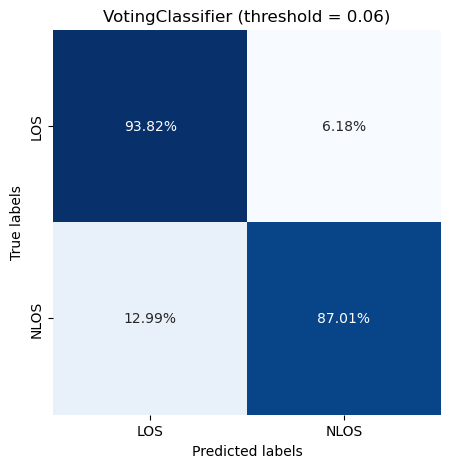

In [96]:
estimators = [('pipe' + str(i+1), top_pipelines[i]) for i in range(9)]
#integrated_classifier = [VotingClassifier(estimators= estimators, voting='soft'),
#                         StackingClassifier(estimators=estimators[:], final_estimator=top_pipelines[2].named_steps['estimator'])]

#for ax_idx, estimator in enumerate(integrated_classifier): 
vc = VotingClassifier(estimators= estimators, voting='soft')
vc.fit(X_train, y_train)


y_prob = vc.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:,1], drop_intermediate = True)
optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]

y_pred = (y_prob[:, 1] >= optimal_threshold).astype(int)  # Assuming binary classification
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the {vc.__class__.__name__} Classifier:", accuracy)
cm = confusion_matrix(y_test, y_pred, normalize = 'true')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))    
sns.heatmap(cm, annot=True,  cbar = False, cmap="Blues", fmt=".2%", xticklabels=class_names, yticklabels=class_names, ax = ax)
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.set_title(f'{vc.__class__.__name__} (threshold = {custom_threshold:.2f})')

This analysis indicates that voting classifier is not a proper candidate since the overal classification accuracy is not higher than base estimators. 

### 1- Investigating which stacking architecture has the best performance

,Accuracy,F1,AUC,fit/pred. time [s]
GradientBoostingClassifier,0.979592,0.775194,0.823931,1.400889
AdaBoostClassifier,0.979592,0.775194,0.823931,1.026154
LogisticRegression,0.946517,0.623762,0.886025,0.976667
SGDClassifier,0.945813,0.620690,0.885653,1.295228
MLPClassifier,0.940183,0.600939,0.888799,3.486024
GaussianNB,0.935961,0.591928,0.898810,1.192698
ExtraTreesClassifier,0.934553,0.582960,0.891944,0.988020
SVC,0.930331,0.571429,0.895833,1.387007
RandomForestClassifier,0.930331,0.567686,0.889712,1.963057
Average,0.946986,0.634420,0.876071,1.523972


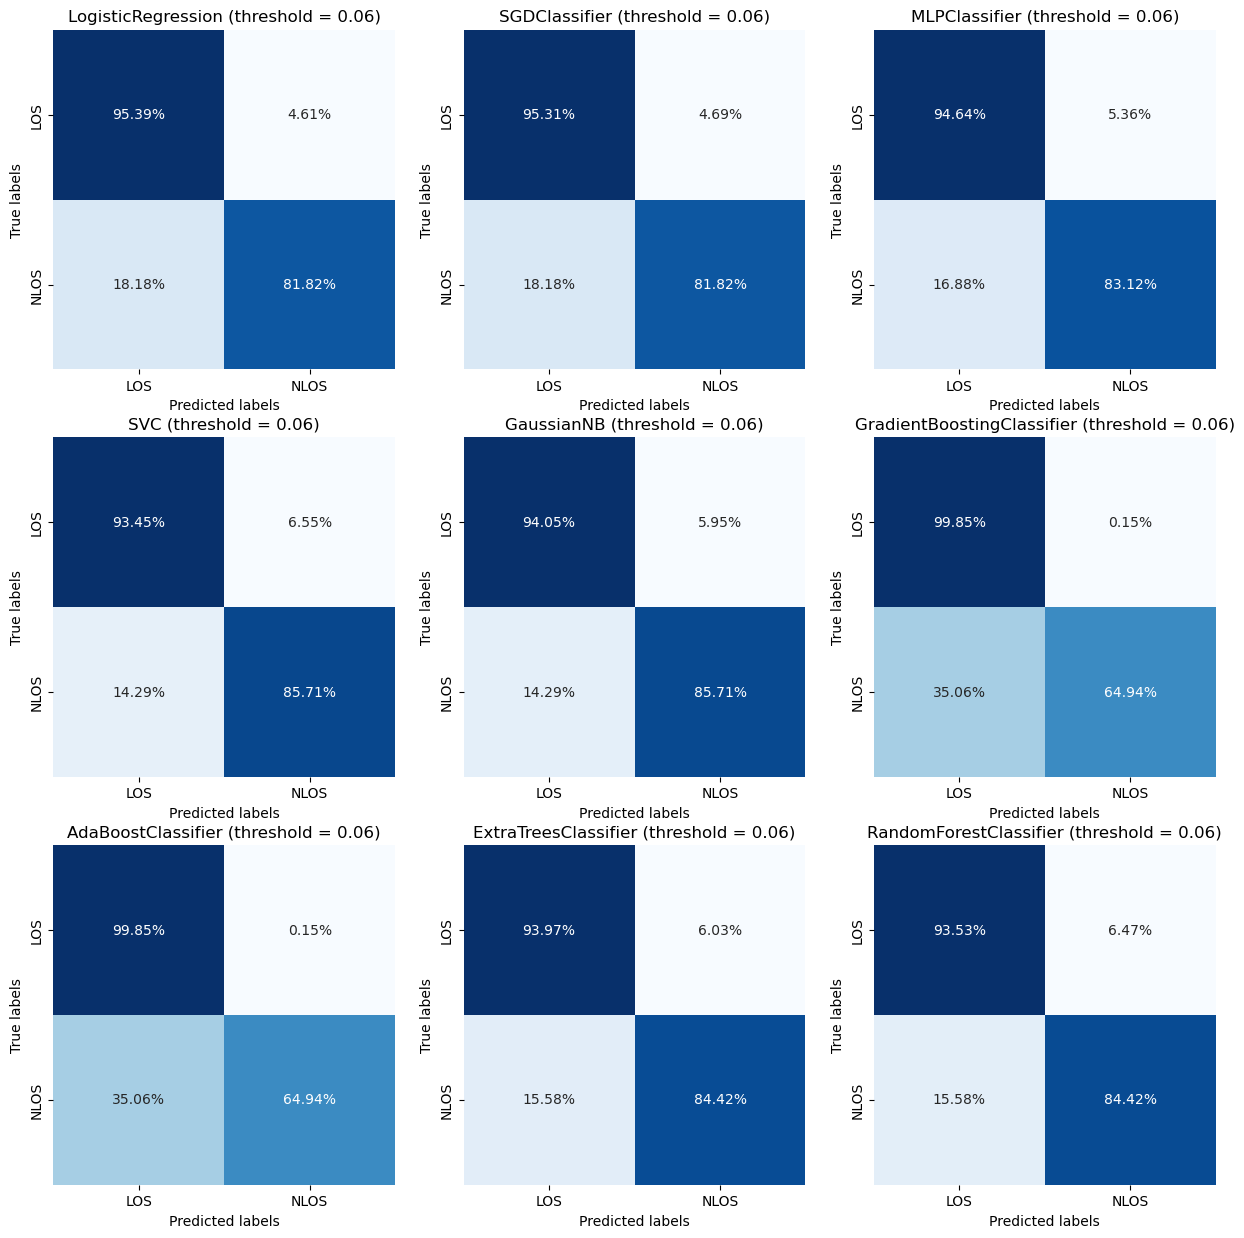

In [97]:
stacking_performance = {'name':[], "Accuracy":[], 'F1':[], 'AUC':[], 'fit/pred. time [s]': []}
SC_pipes = []
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))    

for idx, pipeline in enumerate(top_pipelines):
    row, col = divmod(idx, 3)
    base_estimators = [base for base in estimators if base != estimators[idx]] #selected all piplines except the one that is selected asthe final estimator
    final_estimator = pipeline.named_steps['estimator']
    
    SC = StackingClassifier(estimators=base_estimators, final_estimator = final_estimator, cv = 'prefit')
    SC_pipes.append(SC)
    
    start_time = time.time()
    SC.fit(X_train, y_train)
    y_SC_prob = SC.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_SC_prob[:,1], drop_intermediate = True)
    optimal_threshold_index = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_threshold_index]

    y_SC_pred = (y_SC_prob[:, 1] >= optimal_threshold).astype(int)  
    end_time = time.time()
    accuracy = accuracy_score(y_test, y_SC_pred)
    f1 = f1_score(y_test, y_SC_pred)
    auc = roc_auc_score(y_test, y_SC_pred)

    stacking_performance['name'] += [final_estimator.__class__.__name__]
    stacking_performance['Accuracy'] += [accuracy]
    stacking_performance['F1'] += [f1]
    stacking_performance['AUC'] += [auc]
    stacking_performance['fit/pred. time [s]'] += [end_time - start_time]

    #f1 is a proper metrics when there is uneven class distribution
    #print(f"F-1 score of the {final_estimator.__class__.__name__} as a final classifier:", f1)



    cm = confusion_matrix(y_test, y_SC_pred, normalize = 'true')

    sns.heatmap(cm, annot=True,  cbar = False, cmap="Blues", fmt=".2%", xticklabels=class_names, yticklabels=class_names, ax = ax[row, col])
    ax[row, col].set_xlabel("Predicted labels")
    ax[row, col].set_ylabel("True labels")
    ax[row, col].set_title(f'{final_estimator.__class__.__name__} (threshold = {custom_threshold:.2f})')

p_table = pd.DataFrame(stacking_performance)
p_table.set_index(p_table.columns[0], inplace=True)
p_table.index.name = None 
p_table_sorted = p_table.sort_values(by='Accuracy', ascending = False)

avg_values = p_table_sorted.mean()
# Add the average values as a new row
p_table_sorted.loc['Average'] = avg_values
std_values = p_table_sorted.std()
# Add the standard deviation values as a new row
p_table_sorted.loc['Std Dev'] = std_values
p_table_sorted = p_table_sorted.style.set_caption(f'sorted by accuracy, Noise = {SNRdB[2]}')
p_table_sorted
#print(p_table_sorted.to_latex())

In [100]:
max_est_name = p_table['Accuracy'].idxmax()
print("The best final classifier according to accuracy metric is:", max_est_name)
max_acc_pipe = p_table.index.get_loc(p_table['Accuracy'].idxmax())
print("Index number of the best final estimator is:", max_acc_pipe)
final_classifier = SC_pipes[max_acc_pipe]
final_classifier

The best final classifier according to accuracy metric is: GradientBoostingClassifier
Index number of the best final estimator is: 5


StackingClassifier(cv='prefit',
                   estimators=[('pipe1',
                                Pipeline(steps=[('scaler', RobustScaler()),
                                                ('transformer',
                                                 KernelPCA(random_state=47)),
                                                ('estimator',
                                                 LogisticRegression(C=100.0,
                                                                    class_weight={0: 1,
                                                                                  1: 2},
                                                                    max_iter=500,
                                                                    random_state=1234))])),
                               ('pipe2',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('transformer',
                                                 PCA(random_state=47)),
                                                ('estimator',
                                                 SGDClassifi...
                                                 KernelPCA(random_state=47)),
                                                ('estimator',
                                                 ExtraTreesClassifier(max_depth=10,
                                                                      min_samples_split=10,
                                                                      random_state=1234))])),
                               ('pipe9',
                                Pipeline(steps=[('scaler', StandardScaler()),
                                                ('transformer',
                                                 PCA(random_state=47)),
                                                ('estimator',
                                                 RandomForestClassifier(n_estimators=200,
                                                                        random_state=1234))]))],
                   final_estimator=GradientBoostingClassifier(n_estimators=50,
                                                              random_state=1234))

FINISHHHHHHHHHHHHHHHHHHHHHHHHHHHHHHH ---> NEW codes for novel ideas will be added after this breakpoint reminder

### 2- Investigating the effect of noise floor using the best stacking classifier

,SNR,Accuracy,F1,AUC
2,10.000000,0.979592,0.775194,0.823931
3,15.000000,0.925405,0.550847,0.887108
4,20.000000,0.907811,0.498084,0.877807
1,5.000000,0.900774,0.483516,0.880208
0,0.000000,0.881070,0.427119,0.851427
Average,nan,0.946986,0.634420,0.876071
Std Dev,7.905694,0.035396,0.125902,0.023960


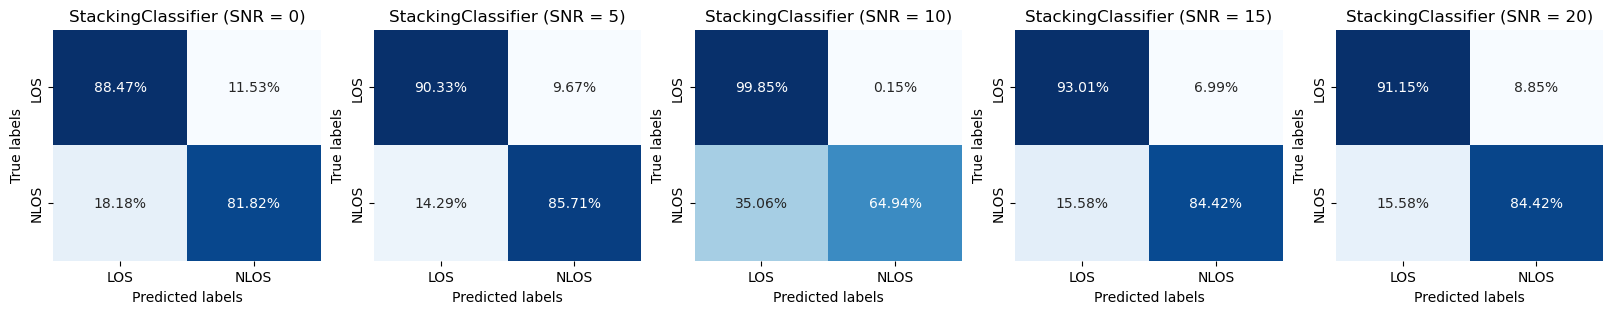

In [108]:
ind = np.array([0, 1, 4, 5, 0+6, 1+6, 4+6, 5+6, 0+12, 1+12, 4+12, 5+12, 0+18, 1+18, 4+18, 5+18, 0+24, 1+24, 4+24, 5+24]) #dimention reduction indices according to pearson correlation analysis
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 3))    
output_SNR = {'SNR': SNRdB, "Accuracy":[], 'F1':[], 'AUC':[]}
BW_100_indices = [1,4,7,10,13] #select thoes indices that include 100MHz BW
FE_SNR = [FE_SNR_PRS[i] for i in BW_100_indices] #select signals with different noise values and the same 100MHz BW
for idx, FE in enumerate(FE_SNR):
    u = FE.reshape(FE.shape[0], -1) #flatten for 5 symbols
    uu = u[:,ind] #select thoes statistical features that are not correlated --> column ind. is calculated before
    x_train, x_test, Y_train, Y_test = train_test_split(uu, labels, test_size=0.2, random_state=42, stratify=labels)
    final_classifier.fit(x_train, Y_train)
    
    y_SNR_prob = final_classifier.predict_proba(x_test)
    fpr, tpr, thresholds = roc_curve(Y_test, y_SNR_prob[:,1], drop_intermediate = True)
    optimal_threshold_index = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_threshold_index]

    y_SNR_pred = (y_SNR_prob[:, 1] >= optimal_threshold).astype(int)
    accuracy = accuracy_score(Y_test, y_SNR_pred)
    output_SNR['Accuracy'] += [accuracy]
    #print(f'SNR = {SNRdB[idx]}')
    #output_SNR['SNR'] = SNRdB[idx]

    #print(f"Accuracy of Stacking Classifier with MLP: {accuracy:.2f}")
    f1 = f1_score(Y_test, y_SNR_pred)
    output_SNR['F1'] += [f1]

    #print(f"F1 Score: {f1:.2f}")


    auc = roc_auc_score(Y_test, y_SNR_pred)
    output_SNR['AUC'] += [auc]

    cm = confusion_matrix(Y_test, y_SNR_pred, normalize = 'true')
    sns.heatmap(cm, annot=True,  cbar = False, cmap="Blues", fmt=".2%", xticklabels=class_names, yticklabels=class_names, ax = ax[idx])
    ax[idx].set_xlabel("Predicted labels")
    ax[idx].set_ylabel("True labels")
    ax[idx].set_title(f'{final_classifier.__class__.__name__} (SNR = {SNRdB[idx]})')

SNR_table = pd.DataFrame(output_SNR)#.sort_values(by='Accuracy', ascending = False)
SNR_table_sorted = SNR_table.sort_values(by='Accuracy', ascending = False)
vg_values = SNR_table_sorted.mean()
# Add the average values as a new row
SNR_table_sorted.loc['Average'] = avg_values
std_values = SNR_table_sorted.std()
# Add the standard deviation values as a new row
SNR_table_sorted.loc['Std Dev'] = std_values
SNR_table_sorted = SNR_table_sorted.style.set_caption(f'sorted by accuracy')
SNR_table_sorted
#print(SNR_table_sorted.to_latex())

The above result is provided without training the stacking classifier again for each noise value. As seen, the predicition accuracy of detecting the LOS (zero) label wirh SNR =10 is 100% like the previous block analysis. when the noise decrease or increase, the model is still robust in LOS detection. however, when the SNR increase, the LOS detection accuracy decrease form 100% to 95 and 92 percent, since the model enable to predict the NLOS labels more, from 73 to 84 and 87 percent. the main binary detection problem is still over because when you change th thresholds to make a trade-off between LOS and NLOS detection accuracy, tpr increase but false negative rate (LOS detection accuracy) is also increase.     

### 3- Investigating how the number of PRS symbols affects the ML model accuracy 

             Accuracy        F1       AUC
SNR Symbol.                              
0   1         0.94722  0.634146   0.89864
    2        0.942294  0.616822  0.902158
    3        0.961999  0.703297  0.900331
    4         0.92259  0.545455  0.891741
    5        0.948628  0.643902  0.905506
5   1        0.942998  0.619718   0.90253
    2        0.940887  0.611111  0.901414
    3        0.909219  0.516854  0.903037
    4         0.94722  0.630542  0.892519
    5        0.943702  0.622642  0.902902
10  1        0.951443  0.649746  0.894751
    2        0.935257   0.59292  0.904559
    3        0.971147  0.754491  0.899046
    4        0.934553  0.586667  0.898065
    5         0.91696  0.535433  0.901008
15  1        0.963406  0.714286  0.907197
    2        0.930331  0.575107  0.901955
    3         0.94722  0.634146   0.89864
    4        0.947924  0.633663  0.892891
    5        0.909923  0.518797  0.903409
20  1        0.959184  0.688172  0.898843
    2        0.943702  0.622642  0

,Accuracy,F1,AUC
SNR,,,
0,0.944546,0.628724,0.899675
5,0.936805,0.600173,0.900480
10,0.941872,0.623851,0.899486
15,0.939761,0.615200,0.900818
20,0.951161,0.654907,0.900724


,Accuracy,F1,AUC
SNR,,,
0,0.014279,0.056781,0.005114
5,0.015589,0.047093,0.004496
10,0.020412,0.083508,0.003629
15,0.020375,0.073176,0.005392
20,0.010096,0.042183,0.004437


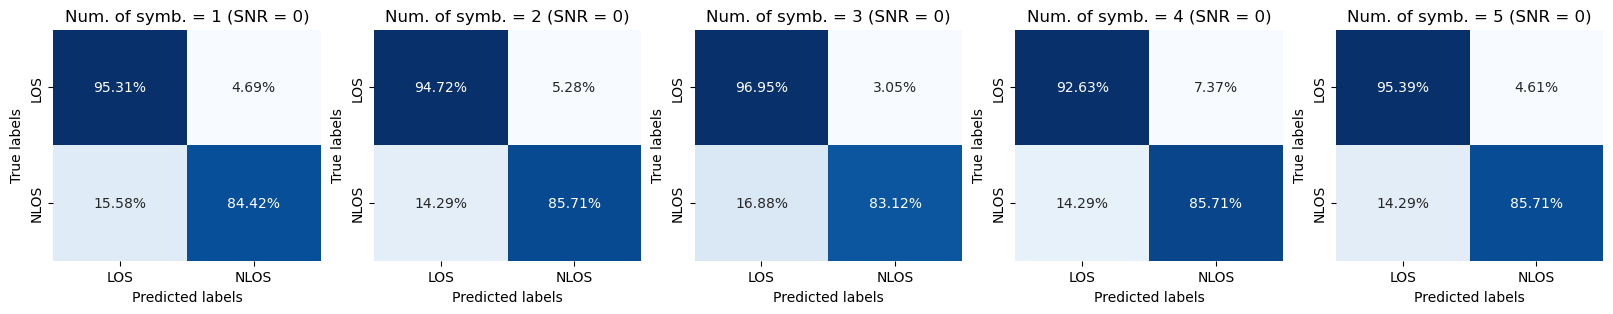

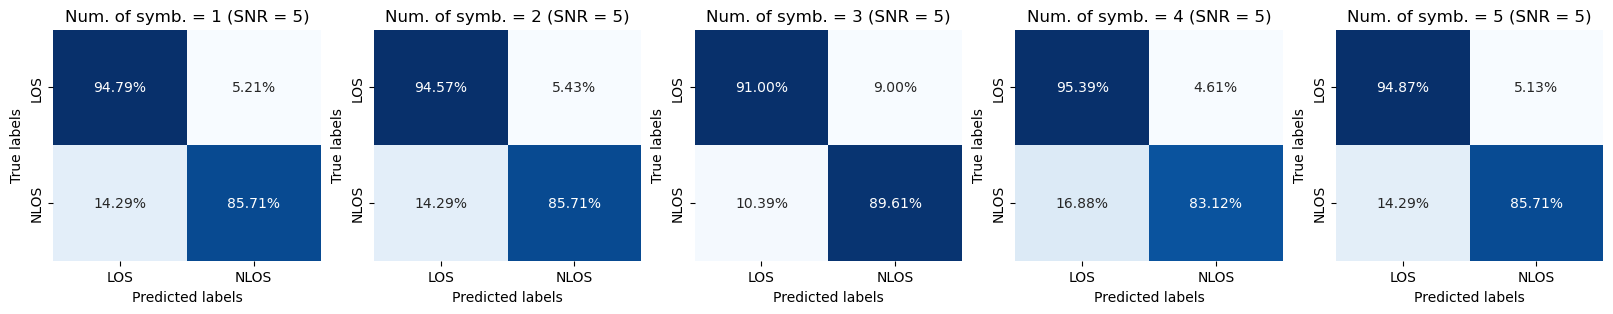

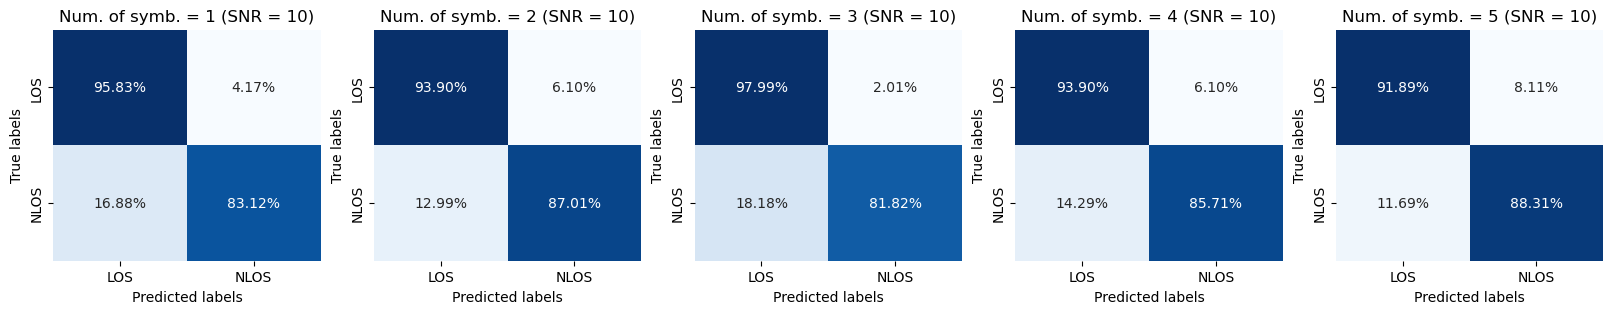

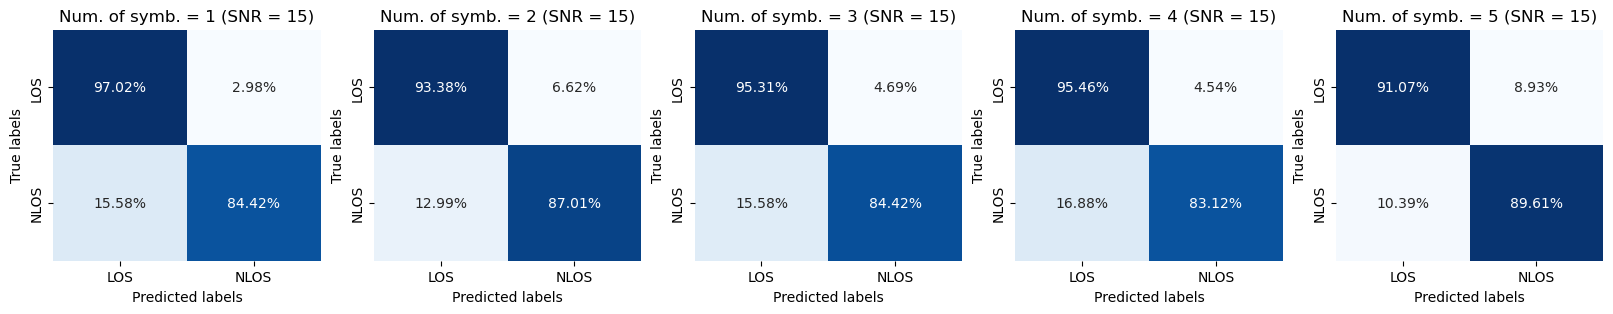

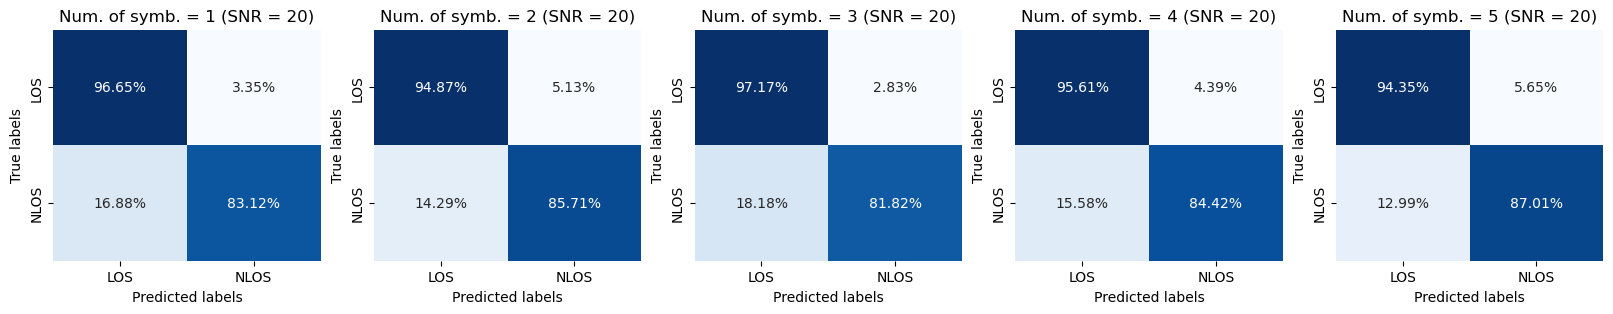

In [104]:
ind_initial = [0, 1, 4, 5]
sym =[1, 2, 3, 4, 5]
output_sym = pd.DataFrame(index=pd.MultiIndex.from_tuples([], names=['SNR', 'Symbol.']),
                                       columns=['Accuracy', 'F1', 'AUC'])

base_models = [pipe for pipe in estimators if pipe != estimators[max_acc_pipe]] # we should define estimators in each iteration as the # of features is changed, 
#max_acc_pipe --> index of the best estimator which is chosen as the final estimator
final_model = estimators[max_acc_pipe][1].named_steps['estimator'] # select the second tuple index (pipeline) and select SVC() as final estimator

for idx, FE in enumerate(FE_SNR): #--> FE_SNR is selected from FE_SNR_PRS 
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 3))    
    for symb in range(5):
        FE = FE.reshape((FE.shape[0], 5, -1)) # reshape to 5 symbol and 6 statisticalfeature for each 
        FE_sym = FE[:,:symb+1,ind_initial]
        FE_sym_reshaped = FE_sym.reshape((FE_sym.shape[0], -1))
        xx_train, xx_test, YY_train, YY_test = train_test_split(FE_sym_reshaped, labels, test_size=0.2, random_state=42, stratify=labels)
        
        new_stacking_pipeline = StackingClassifier(estimators = base_models, final_estimator = final_model, cv=2) #we should define estimators in each iteration as the # of features is changed 
        new_stacking_pipeline.fit(xx_train, YY_train)

        y_sym_SNR_prob = new_stacking_pipeline.predict_proba(xx_test)
        fpr, tpr, thresholds = roc_curve(YY_test, y_sym_SNR_prob[:,1], drop_intermediate = True)
        optimal_threshold_index = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_threshold_index]

        y_sym_SNR_pred = (y_sym_SNR_prob[:, 1] >= optimal_threshold).astype(int)
        accuracy = accuracy_score(YY_test, y_sym_SNR_pred)
        f1 = f1_score(YY_test, y_sym_SNR_pred)
        auc = roc_auc_score(YY_test, y_sym_SNR_pred)
        output_sym.loc[(SNRdB[idx], symb+1), :] = [accuracy, f1, auc]

        cm = confusion_matrix(YY_test, y_sym_SNR_pred, normalize = 'true')
        sns.heatmap(cm, annot=True,  cbar = False, cmap="Blues", fmt=".2%", xticklabels=class_names, yticklabels=class_names, ax = ax[symb])
        ax[symb].set_xlabel("Predicted labels")
        ax[symb].set_ylabel("True labels")
        ax[symb].set_title(f'Num. of symb. = {symb+1} (SNR = {SNRdB[idx]})')
        
        new_stacking_pipeline = None #remove the previous pipeline for a new number of features

print(output_sym)
mean_values = output_sym.groupby(level=0).mean()
std_values = output_sym.groupby(level=0).std()
display(mean_values.style.set_caption(f'Mean Values'))
display(std_values.style.set_caption(f'Std Dev. Values'))

The results indicate that the optimum number of symbols for different SNR values are three symbols if the object is higher predicition accuracy in LOS detection. when the number of PRS symbols increase, the stacking ML model capability to predict NLOS labels decrease for different values of SNRs if the SNR. the reason is that with more # of symbols from one to five, the stacking classifier learns to predict more LOS labels, thus, the tpr decrease. how,ever, the main takeaway is that the mean accuracy value for different SNRs changes in range of 1 percent and the variance is in the order of 0.001. As the result, repetiotion of PRS in different symbols do not essentially change the final performance. 

In [132]:
print(output_sym)
mean_values = output_sym.groupby(level=0).mean()
std_values = output_sym.groupby(level=0).std()
display(mean_values.style.set_caption(f'Mean Values'))
display(std_values.style.set_caption(f'Std Dev. Values'))

             Accuracy        F1       AUC
SNR Symbol.                              
0   1         0.94722  0.634146   0.89864
    2        0.942294  0.616822  0.902158
    3        0.961999  0.703297  0.900331
    4         0.92259  0.545455  0.891741
    5        0.948628  0.643902  0.905506
5   1        0.942998  0.619718   0.90253
    2        0.940887  0.611111  0.901414
    3        0.909219  0.516854  0.903037
    4         0.94722  0.630542  0.892519
    5        0.943702  0.622642  0.902902
10  1        0.951443  0.649746  0.894751
    2        0.935257   0.59292  0.904559
    3        0.971147  0.754491  0.899046
    4        0.934553  0.586667  0.898065
    5         0.91696  0.535433  0.901008
15  1        0.963406  0.714286  0.907197
    2        0.930331  0.575107  0.901955
    3         0.94722  0.634146   0.89864
    4        0.947924  0.633663  0.892891
    5        0.909923  0.518797  0.903409
20  1        0.959184  0.688172  0.898843
    2        0.943702  0.622642  0

,Accuracy,F1,AUC
SNR,,,
0,0.944546,0.628724,0.899675
5,0.936805,0.600173,0.900480
10,0.941872,0.623851,0.899486
15,0.939761,0.615200,0.900818
20,0.951161,0.654907,0.900724


,Accuracy,F1,AUC
SNR,,,
0,0.014279,0.056781,0.005114
5,0.015589,0.047093,0.004496
10,0.020412,0.083508,0.003629
15,0.020375,0.073176,0.005392
20,0.010096,0.042183,0.004437


### 4- Investigating how bandwidth affects the ML model accuracy 

         Accuracy        F1       AUC
SNR PRS                              
0   1    0.917664  0.506329  0.852408
    2     0.88107  0.427119  0.851427
    3    0.837438  0.373984  0.865091
5   1    0.954961  0.652174  0.872125
    2    0.900774  0.483516  0.880208
    3    0.961295  0.685714  0.875473
10  1    0.954258  0.656085  0.883996
    2    0.979592  0.775194  0.823931
    3     0.96974  0.742515  0.892181
15  1    0.938072  0.592593  0.887683
    2    0.925405  0.550847  0.887108
    3    0.947924  0.637255  0.899012
20  1    0.907108  0.492308  0.871314
    2    0.907811  0.498084  0.877807
    3    0.915552   0.52381  0.888021


,Accuracy,F1,AUC
SNR,,,
0,0.878724,0.435810,0.856309
5,0.939010,0.607135,0.875936
10,0.967863,0.724598,0.866703
15,0.937133,0.593565,0.891268
20,0.910157,0.504734,0.879047


,Accuracy,F1,AUC
SNR,,,
0,0.040164,0.066599,0.007621
5,0.033264,0.108362,0.004061
10,0.012771,0.061543,0.037267
15,0.011289,0.043212,0.006713
20,0.004686,0.016771,0.008422


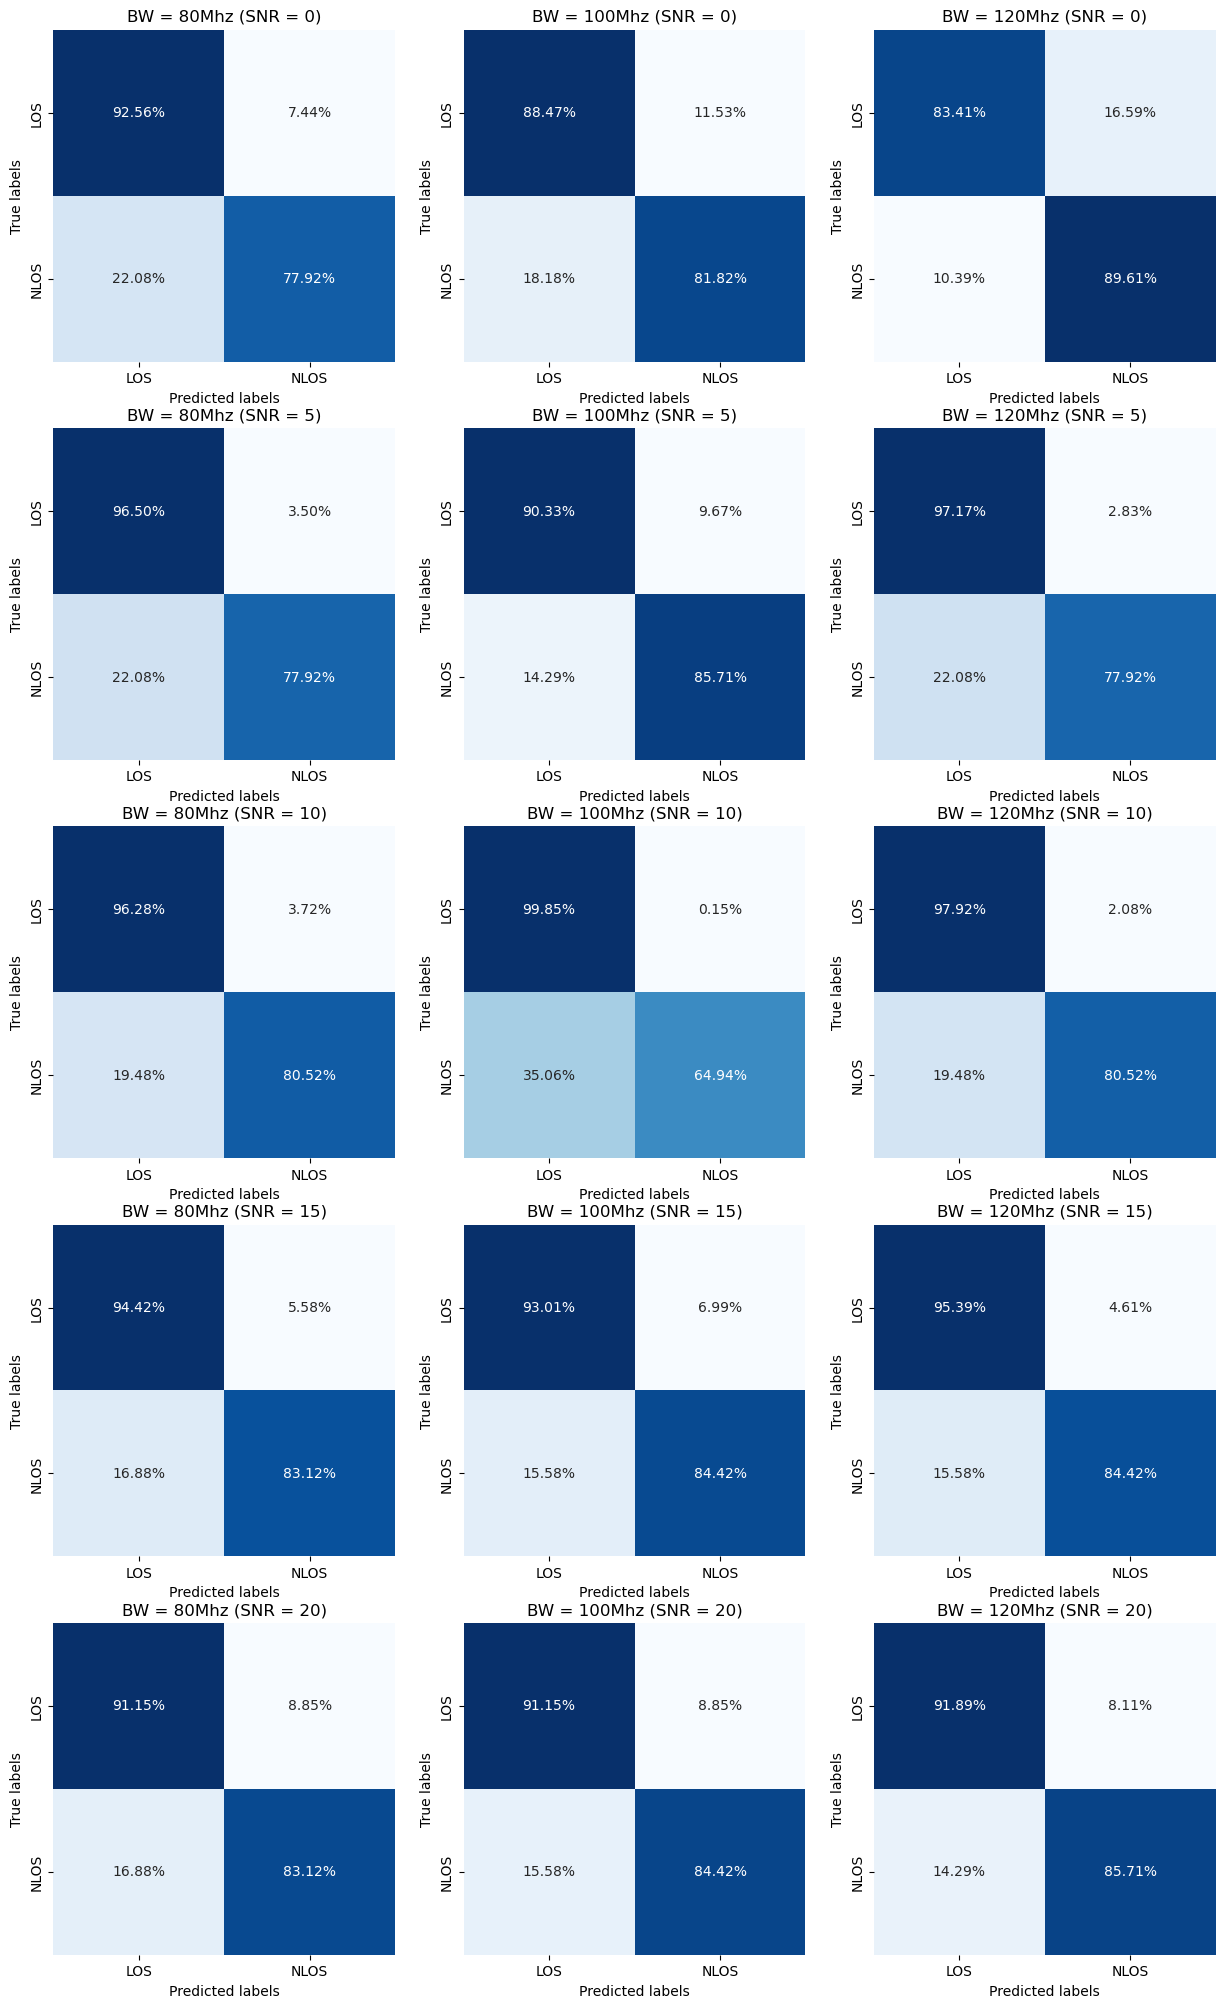

In [121]:
ind = np.array([0, 1, 4, 5, 0+6, 1+6, 4+6, 5+6, 0+12, 1+12, 4+12, 5+12, 0+18, 1+18, 4+18, 5+18, 0+24, 1+24, 4+24, 5+24]) #dimention reduction indices according to pearson correlation analysis
BW = [80, 100, 120]
output_prs = pd.DataFrame(index=pd.MultiIndex.from_tuples([], names=['SNR', 'PRS']),
                                       columns=['Accuracy', 'F1', 'AUC'])

#base_models = [pipe for pipe in estimators if pipe != estimators[2]] #we should define estimators in each iteration as the # of features is changed
#final_model = estimators[2][1].named_steps['estimator'] # select the second tuple index (pipeline) and select SVC() as final estimator
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(15, 25)) 
counter = 0 #to track the PRS BW and make it zero againfor each SNR
s_value = 0 #to track the SNR values    
for idx, F in enumerate(FE_SNR_PRS):
    row, col = divmod(idx, 3)
    p = F.reshape(F.shape[0], -1) #flatten for 5 symbols
    pp = p[:,ind] #select thoes statistical features that are not correlated --> column ind. is calculated before
    xxx_train, xxx_test, YYY_train, YYY_test = train_test_split(pp, labels, test_size=0.2, random_state=42, stratify=labels)
        
    #new_stacking_pipeline = StackingClassifier(estimators = base_models, final_estimator = final_model, cv=2) #we should define estimators in each iteration as the # of features is changed 
    #new_stacking_pipeline.fit(xx_train, YY_train)
    final_classifier.fit(xxx_train, YYY_train)
    
    y_prs_prob = final_classifier.predict_proba(xxx_test)
    fpr, tpr, thresholds = roc_curve(YYY_test, y_prs_prob[:,1], drop_intermediate = True)
    optimal_threshold_index = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_threshold_index]

    y_prs_pred = (y_prs_prob[:, 1] >= optimal_threshold).astype(int)

    accuracy = accuracy_score(YYY_test, y_prs_pred)
    f1 = f1_score(YYY_test, y_prs_pred)
    auc = roc_auc_score(YYY_test, y_prs_pred)
    output_prs.loc[(s_value, counter+1), :] = [accuracy, f1, auc]
    

    cm = confusion_matrix(YYY_test, y_prs_pred, normalize = 'true')
    sns.heatmap(cm, annot=True,  cbar = False, cmap="Blues", fmt=".2%", xticklabels=class_names, yticklabels=class_names, ax = ax[row, col])
    ax[row][col].set_xlabel("Predicted labels")
    ax[row][col].set_ylabel("True labels")
    ax[row][col].set_title(f'BW = {BW[counter]}Mhz (SNR = {s_value})')

    
    counter += 1
    if counter-1 == 2: #check counter for PRS and reset it if it reaches to 3 PRS BW for each SNR
        counter = 0
        s_value += 5

print(output_prs)
mean_values = output_prs.groupby(level=0).mean()
std_values = output_prs.groupby(level=0).std()
display(mean_values.style.set_caption(f'Mean Values'))
display(std_values.style.set_caption(f'Std Dev. Values'))
    

When the SNR is not high enough, increasing the BW can increase the predicition acuracy but its effect is not two much (less than 5 percent). In higher SNR values, increasing the BW has not any effects on the prediction accuracy and it decrease the LOS detection accuracy since the ML model provides more accuracy in NLOS prediction, thus, the LOS prediction accuracy  decrease. 

### 5- Investigating ML model robustness when BS is changed

In [106]:
FE_BS = np.load('FE_BS.npy')
labels_f = np.load('labels.npy') #all BS labels
print(FE_BS.shape)
print(labels_f.shape)

(18, 7102, 30)
(7102, 18)


         Accuracy        F1       AUC
BS num.                              
1        0.914849  0.521739  0.816022
2        0.956369      0.69  0.939198
3        0.804363  0.379464  0.885057
4        0.857847  0.482051  0.875051
5        0.918367  0.539683  0.814437
6        0.940183  0.593301  0.849578
7        0.962702  0.710383  0.901775
8        0.949331  0.686957  0.940005
9         0.85855  0.477922  0.900209
10       0.847994  0.495327  0.877969
11         0.8114  0.352657   0.86441
12       0.979592  0.775194  0.823931
13       0.936664  0.637097   0.94922
14       0.947924  0.686441  0.907867
15       0.878958  0.540107  0.882156
16       0.893033  0.424242  0.769937
17       0.818438   0.31746  0.820084
18        0.96411  0.705202  0.926127
Mean      0.90226  0.556402  0.874613
Std      0.057419  0.136756  0.050659


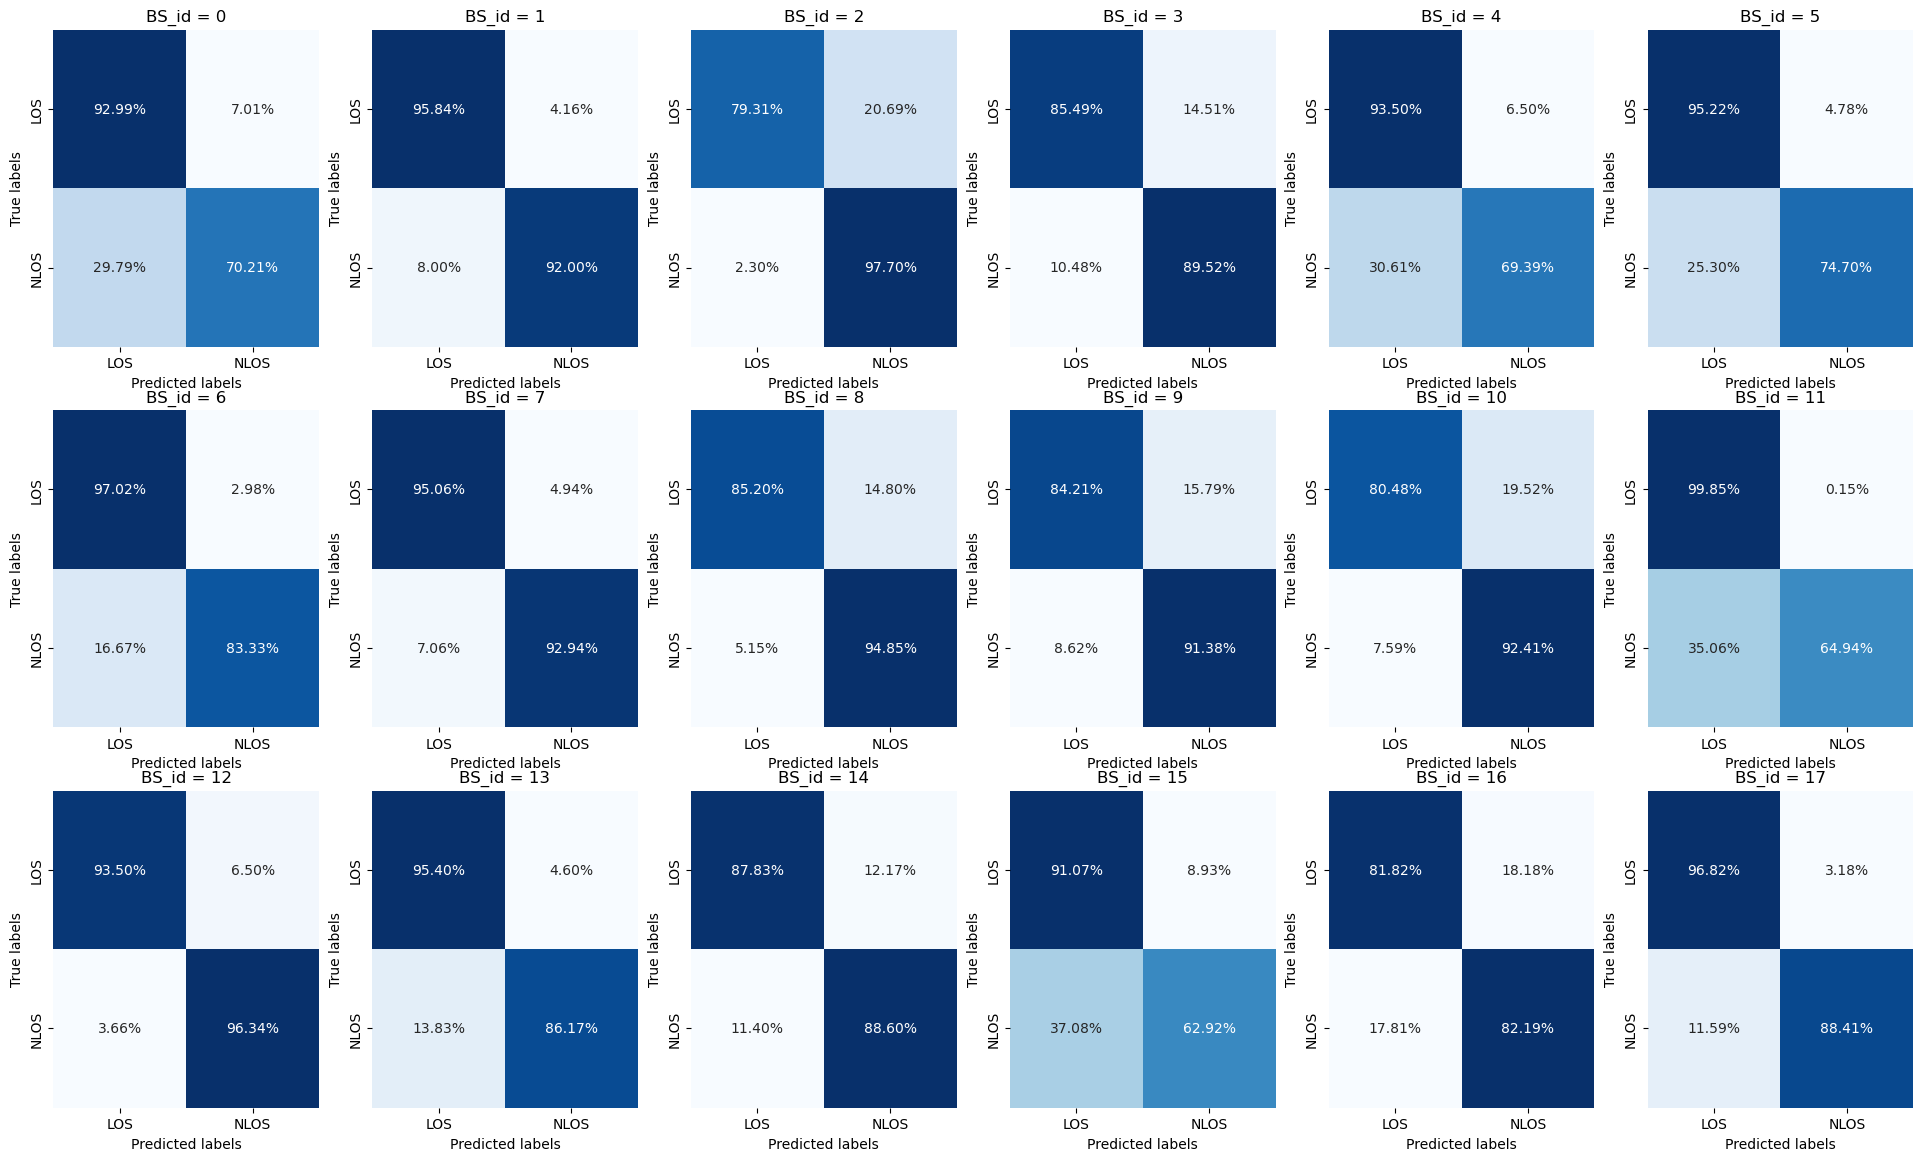

In [107]:
output_BS = pd.DataFrame(columns=['Accuracy', 'F1', 'AUC'])
fig, ax = plt.subplots(nrows=3, ncols=6, figsize=(24, 14)) 
for idx, F in enumerate(FE_BS):
    row, col = divmod(idx, 6)
    #p = F.reshape(F.shape[0], -1) #flatten for 5 symbols
    pp = F[:,ind] #select thoes statistical features that are not correlated --> column ind. is calculated before
    xxx_train, xxx_test, YYY_train, YYY_test = train_test_split(pp, labels_f[:,idx], test_size=0.2, random_state=42, stratify=labels_f[:,idx])
    #bs_stacking_pipeline = StackingClassifier(estimators = base_models, final_estimator = final_model, cv=2) #we should define estimators in each iteration as the # of features is changed 
    #bs_stacking_pipeline.fit(xxx_train, YYY_train)
    final_classifier.fit(xxx_train, YYY_train)
    
    y_bs_prob = final_classifier.predict_proba(xxx_test)
    #y_prs_prob = bs_stacking_pipeline.predict_proba(xxx_test)

    fpr, tpr, thresholds = roc_curve(YYY_test, y_bs_prob[:,1], drop_intermediate = True)
    optimal_threshold_index = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_threshold_index]

    y_bs_pred = (y_bs_prob[:, 1] >= optimal_threshold).astype(int)

    accuracy = accuracy_score(YYY_test, y_bs_pred)
    f1 = f1_score(YYY_test, y_bs_pred)
    auc = roc_auc_score(YYY_test, y_bs_pred)
    output_BS.loc[(idx+1), :] = [accuracy, f1, auc]
    

    cm = confusion_matrix(YYY_test, y_bs_pred, normalize = 'true')
    sns.heatmap(cm, annot=True,  cbar = False, cmap="Blues", fmt=".2%", xticklabels=class_names, yticklabels=class_names, ax = ax[row, col])
    ax[row][col].set_xlabel("Predicted labels")
    ax[row][col].set_ylabel("True labels")
    ax[row][col].set_title(f'BS_id = {idx}')


mean_values = output_BS.mean()
std_values = output_BS.std()
stats_df = pd.DataFrame({'Mean': mean_values, 'Std': std_values})
output_BS = pd.concat([output_BS, stats_df.transpose()])
output_BS.index.name = 'BS num.'
print(output_BS)


with a two fold cross validation and fitting a new stacking model for each BS according to the predefined structure, the accuracy of the model to predict all the BS labels can reach to 99 percent for majrity of BSs. the time for fitting the model is also affordabe (roughly 20 second for each BS)

### 6- Investigating ML model robustness when dataset changes

In [129]:
import pickle
with open('DS_FE', 'rb') as file:
    DS_FE = pickle.load(file)

with open('DS_labels', 'rb') as file:
    DS_labels = pickle.load(file)

         Accuracy        F1       AUC
dataset                              
1        0.979592  0.775194  0.823931
2        0.979592  0.775194  0.823931
3        0.962623  0.728205  0.894147
4        0.979592  0.775194  0.823931
5        0.979592  0.775194  0.823931
Mean     0.976198  0.765796  0.837974
Std      0.007589  0.021014  0.031401


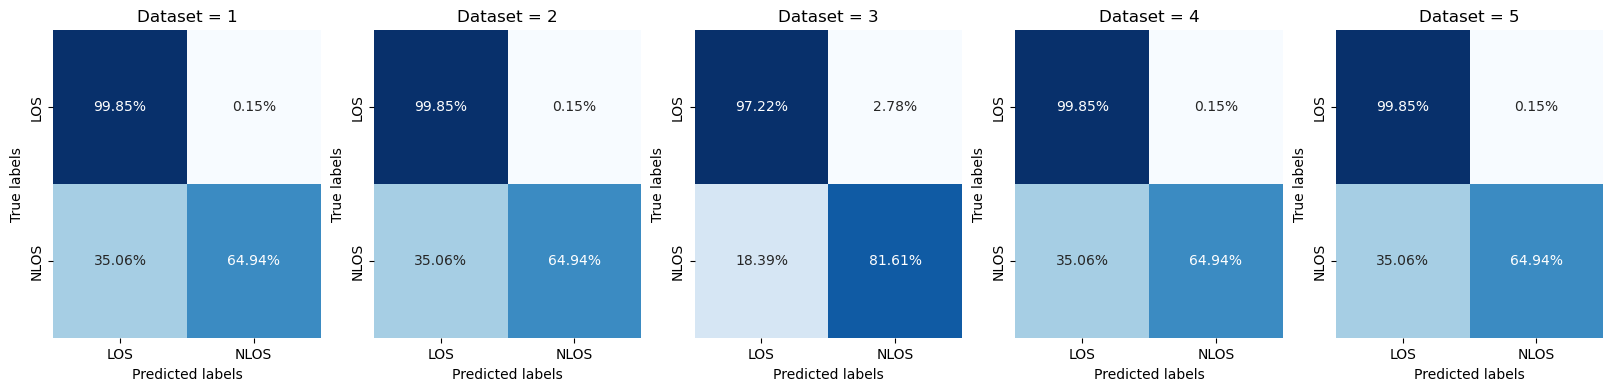

In [130]:
output_DS = pd.DataFrame(columns=['Accuracy', 'F1', 'AUC'])

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 4)) 
for idx, F in enumerate(DS_FE):
    #row, col = divmod(idx, 6)
    #p = F.reshape(F.shape[0], -1) #flatten for 5 symbols
    pp = F[:,ind] #select thoes statistical features that are not correlated --> column ind. is calculated before
    xxxx_train, xxxx_test, YYYY_train, YYYY_test = train_test_split(pp, DS_labels[idx], test_size=0.2, random_state=42, stratify=DS_labels[idx])
        
    #bs_stacking_pipeline = StackingClassifier(estimators = base_models, final_estimator = final_model, cv=2) #we should define estimators in each iteration as the # of features is changed 
    #bs_stacking_pipeline.fit(xxx_train, YYY_train)
    final_classifier.fit(xxxx_train, YYYY_train)
    
    y_ds_prob = final_classifier.predict_proba(xxxx_test)
    #y_prs_prob = bs_stacking_pipeline.predict_proba(xxx_test)

    fpr, tpr, thresholds = roc_curve(YYYY_test, y_ds_prob[:,1], drop_intermediate = True)
    optimal_threshold_index = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_threshold_index]

    y_ds_pred = (y_ds_prob[:, 1] >= optimal_threshold).astype(int)

    accuracy = accuracy_score(YYYY_test, y_ds_pred)
    f1 = f1_score(YYYY_test, y_ds_pred)
    auc = roc_auc_score(YYYY_test, y_ds_pred)
    output_DS.loc[(idx+1), :] = [accuracy, f1, auc]
    

    cm = confusion_matrix(YYYY_test, y_ds_pred, normalize = 'true')
    sns.heatmap(cm, annot=True,  cbar = False, cmap="Blues", fmt=".2%", xticklabels=class_names, yticklabels=class_names, ax = ax[idx])
    ax[idx].set_xlabel("Predicted labels")
    ax[idx].set_ylabel("True labels")
    ax[idx].set_title(f'Dataset = {idx+1}')
    #fig.suptitle('BS_id = 11, SNR = 10 ', fontsize=12) #SNR = 10, BS = 11

mean_values = output_DS.mean()
std_values = output_DS.std()
stats_df = pd.DataFrame({'Mean': mean_values, 'Std': std_values})
output_DS = pd.concat([output_DS, stats_df.transpose()])
output_DS.index.name = 'dataset'
print(output_DS)
#print(output_DS.to_latex())

Without a new stacking classifier, pretrained classifier has a high accuracy in predicting unseen datasets (dataset from 2 to 5). It means that random change in clutters inside the InF grid has not a big effect on robustness of the ML model